In [21]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [22]:
FILE_DIR = 'datasets/сleaned'
OUT_DIR = 'datasets/forecast'
PATTERN = '*_cleaned.csv'
METRICS_FILE = 'datasets/forecast_metrics/metrics_summary.csv'
TEST_DAYS = 7  # число дней для тестовой выборки

In [23]:
def read_and_agg(fp):
    """
    Убирает пропуски и ошибки
    Агрегирует поминутные данные до дневных
    """
    df = pd.read_csv(fp, parse_dates=['Datetime'])
    df = df.sort_values('Datetime')
    df = df[df['IsMissing'] == 0].dropna(subset=['Final_Close'])

    # Превращаем Datetime в дату
    df['Date'] = pd.to_datetime(df['Datetime'].dt.date)

    # Группируем по дням
    daily = (
        df.groupby('Date')
          .agg({'Final_Close': 'mean'})
          .reset_index()
          .rename(columns={'Final_Close': 'Price'})
    )
    return daily

def split_data(daily, test_days):
    train = daily.iloc[:-test_days].copy()
    test = daily.iloc[-test_days:].copy()

    # to_datetime с ежедневной частотой 
    train['Date'] = pd.to_datetime(train['Date'])
    train = train.set_index('Date').asfreq('D')
    train['Price'] = train['Price'].interpolate(method='time')

    test['Date'] = pd.to_datetime(test['Date'])
    test = test.set_index('Date').asfreq('D')
    test['Price'] = test['Price'].interpolate(method='time')

    return train, test

def stationarize(train):
    """
    Проверяем на стационарность.
    Если P-значение > 0.05, делаем разность первого порядка.
    Возвращаем (DataFrame, порядок d).
    """
    adf_res = adfuller(train['Price'])
    if adf_res[1] > 0.05:
        train['Diff'] = train['Price'].diff().dropna()
        st_train = train.dropna(subset=['Diff'])
        return st_train, 1
    return train, 0

In [29]:
# SES
def ses_forecast(train, steps):

    preds = []
    cur = train['Price'].copy()
    idx = cur.index[-1]

    for _ in range(steps):
        model = SimpleExpSmoothing(cur).fit(optimized=True)
        alpha = model.params['smoothing_level']  # Получаем значение alpha
        print(f"Параметр SES: alpha={alpha:.4f}")

        f = model.forecast(1).iloc[-1]

        lo = f * 0.95
        hi = f * 1.05
        preds.append((f, lo, hi))

        idx += pd.Timedelta(days=1)
        cur.loc[idx] = f

    return preds

# ARIMA
def arima_forecast(train, steps):

    st_train, d = stationarize(train.copy())

    # Если d=1, работаем с train['Diff'], иначе с train['Price']
    series_for_fit = st_train['Diff'] if d == 1 else train['Price']

    best_aic = float('inf')
    best_order = None

    for p in range(1, 3):
        for q in range(1, 3):
            try:
                model = ARIMA(series_for_fit, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p, d, q)
            except:
                continue
    if best_order:
        print(f"Выбранные параметры ARIMA: p={best_order[0]}, d={best_order[1]}, q={best_order[2]} (AIC={best_aic:.2f})")


    preds = []
    cur = train['Price'].copy()
    idx = cur.index[-1]

    for _ in range(steps):
        model = ARIMA(
            cur, 
            order=best_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit()

        f = model.forecast(1).iloc[-1]

        lo = f * 0.95
        hi = f * 1.05
        preds.append((f, lo, hi))

        idx += pd.Timedelta(days=1)
        cur.loc[idx] = f

    return preds

# Линейная регрессия
def linear_forecast(train, steps):
    train = train.reset_index()
    train['Lag1'] = train['Price'].shift(1)
    train['Lag2'] = train['Price'].shift(2)
    train = train.dropna()

    X = train[['Lag1', 'Lag2']]
    y = train['Price']

    model = LinearRegression()
    model.fit(X, y)

    preds = []
    last_values = train[['Lag1', 'Lag2']].iloc[-1].values

    for _ in range(steps):
        pred = model.predict([last_values])[0]
        preds.append((pred, pred * 0.95, pred * 1.05))

        last_values = [pred, last_values[0]]

    return preds

In [25]:
def plot_forecast(test, ses_preds, ari_preds, lin_preds):
    plt.figure(figsize=(12, 6))

    real_dates = test.index[-14:]
    real_vals = test['Price'][-14:]
    plt.plot(real_dates, real_vals, label='Исходные данные',
             color='blue', marker='o', linestyle='-')

    # ARIMA (3 дня)
    ari_dates = [test.index[-1] + pd.Timedelta(days=i) for i in range(1, len(ari_preds) + 1)]
    ari_vals = [x[0] for x in ari_preds]
    ari_lo = [x[1] for x in ari_preds]
    ari_hi = [x[2] for x in ari_preds]

    plt.plot([real_dates[-1]] + ari_dates, [real_vals.iloc[-1]] + ari_vals,
             color='red', marker='o', linestyle='-', label='ARIMA')
    plt.fill_between(ari_dates, ari_lo, ari_hi, color='red', alpha=0.2)

    # SES (3 дня)
    ses_dates = [test.index[-1] + pd.Timedelta(days=i) for i in range(1, len(ses_preds) + 1)]
    ses_vals = [x[0] for x in ses_preds]
    ses_lo = [x[1] for x in ses_preds]
    ses_hi = [x[2] for x in ses_preds]

    # Linear
    lin_dates = [test.index[-1] + pd.Timedelta(days=i) for i in range(1, len(lin_preds) + 1)]
    lin_vals = [x[0] for x in lin_preds]
    plt.plot([real_dates[-1]] + lin_dates, [real_vals.iloc[-1]] + lin_vals,
             color='orange', marker='o', linestyle='-', label='Linear')


    plt.plot([real_dates[-1]] + ses_dates, [real_vals.iloc[-1]] + ses_vals,
             color='green', marker='o', linestyle='-', label='SES')
    plt.fill_between(ses_dates, ses_lo, ses_hi, color='blue', alpha=0.2)

    plt.title('Прогноз цены на 3 дня вперёд')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def main():
    file_paths = glob.glob(os.path.join(FILE_DIR, PATTERN))
    os.makedirs(OUT_DIR, exist_ok=True)

    metrics_list = []

    for fp in file_paths:
        print(f"\nОбработка файла: {fp}")

        daily = read_and_agg(fp)
        ticker = os.path.basename(fp).split('_')[0]

        if len(daily) < TEST_DAYS:
            print("Слишком мало данных для прогноза.")
            continue

        train, test = split_data(daily, TEST_DAYS)

        ses_preds = ses_forecast(train, 3)
        ari_preds = arima_forecast(train, 3)
        lin_preds = linear_forecast(train, 3)

        print(f"\nПрогнозы для {ticker}:")
        print("SES:", [round(x[0], 3) for x in ses_preds])
        print("ARIMA:", [round(x[0], 3) for x in ari_preds])
        print("Linear:", [round(x[0], 3) for x in lin_preds])

        # Метрики за 3 дня
        test_3 = test['Price'][:3]
        ses_vals_3 = [x[0] for x in ses_preds]
        ari_vals_3 = [x[0] for x in ari_preds]
        lin_vals_3 = [x[0] for x in lin_preds]


        ses_mae = mean_absolute_error(test_3, ses_vals_3)
        ses_mape = mean_absolute_percentage_error(test_3, ses_vals_3)
        try:
            ses_r2 = r2_score(test_3, ses_vals_3)
        except:
            ses_r2 = float('nan')

        ari_mae = mean_absolute_error(test_3, ari_vals_3)
        ari_mape = mean_absolute_percentage_error(test_3, ari_vals_3)
        try:
            ari_r2 = r2_score(test_3, ari_vals_3)
        except:
            ari_r2 = float('nan')

        lin_mae = mean_absolute_error(test_3, lin_vals_3)
        lin_mape = mean_absolute_percentage_error(test_3, lin_vals_3)
        try:
            lin_r2 = r2_score(test_3, lin_vals_3)
        except:
            lin_r2 = float('nan')

        print("\n=== Итоговые метрики (3 дня) ===")
        print(f"SES:   MAE={ses_mae:.3f}, MAPE={ses_mape:.3f}, R2={ses_r2:.3f}")
        print(f"ARIMA: MAE={ari_mae:.3f}, MAPE={ari_mape:.3f}, R2={ari_r2:.3f}")
        print(f"Linear: MAE={lin_mae:.3f}, MAPE={lin_mape:.3f}, R2={lin_r2:.3f}")

        # Метрики по каждому дню (1, 2, 3)
        print("\n=== Метрики по каждому дню ===")
        for i in range(3):
            act = test_3.iloc[i]
            ses_pred = ses_vals_3[i]
            ari_pred = ari_vals_3[i]
            lin_pred = lin_vals_3[i]  # Значение линейной регрессии для текущего дня

            mae_ses_day = mean_absolute_error([act], [ses_pred])
            mape_ses_day = mean_absolute_percentage_error([act], [ses_pred])

            mae_ari_day = mean_absolute_error([act], [ari_pred])
            mape_ari_day = mean_absolute_percentage_error([act], [ari_pred])

            mae_lin_day = mean_absolute_error([act], [lin_pred])
            mape_lin_day = mean_absolute_percentage_error([act], [lin_pred])

            print(f"День {i+1}:")
            print(f"  SES:   MAE={mae_ses_day:.4f}, MAPE={mape_ses_day:.4f}, R2=nan")
            print(f"  ARIMA: MAE={mae_ari_day:.4f}, MAPE={mape_ari_day:.4f}, R2=nan")
            print(f"  Linear: MAE={mae_lin_day:.4f}, MAPE={mape_lin_day:.4f}, R2=nan")



        

        # метрики в общий список
        metrics_list.append({
            'Ticker': ticker,
            'SES_MAE_3': ses_mae,
            'SES_MAPE_3': ses_mape,
            'SES_R2_3': ses_r2,
            'ARIMA_MAE_3': ari_mae,
            'ARIMA_MAPE_3': ari_mape,
            'ARIMA_R2_3': ari_r2,
            'Linear_MAE_3': lin_mae,
            'Linear_MAPE_3': lin_mape,
            'Linear_R2_3': lin_r2
        })

        plot_forecast(test, ses_preds, ari_preds, lin_preds)

    if metrics_list:
        out_df = pd.DataFrame(metrics_list)
        out_df.to_csv(METRICS_FILE, index=False)
        print(f"\nВсе метрики сохранены в файл {METRICS_FILE}")


## Методы прогнозирования

- **MAE**: Средняя абсолютная ошибка.
- **MAPE**: Средняя абсолютная процентная ошибка.
- **R2**: Доля объяснённой вариации данных (коэффициент детерминации).

---

## Метрики качества

| **Метрика**       | **Хорошее значение**  | **Среднее значение**  | **Плохое значение**    |
|-------------------|-----------------------|-----------------------|------------------------|
| **MAE**           | ≤ 5                   | 5–10                  | > 10                   |
| **APE**           | ≤ 5%                  | 5–10%                 | > 10%                  |
| **R2**            | ≥ 0.8                 | 0.5–0.8               | < 0.5                  |



Обработка файла: datasets/сleaned\ALRS_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=2, d=0, q=2 (AIC=3121.55)

Прогнозы для ALRS:
SES: [np.float64(49.998), np.float64(49.998), np.float64(49.998)]
ARIMA: [np.float64(49.891), np.float64(49.904), np.float64(49.966)]
Linear: [np.float64(50.167), np.float64(50.082), np.float64(50.105)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=1.008, MAPE=0.021, R2=-3.213
ARIMA: MAE=0.930, MAPE=0.019, R2=-2.851
Linear: MAE=1.128, MAPE=0.023, R2=-3.940

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.3191, MAPE=0.0064, R2=nan
  ARIMA: MAE=0.2126, MAPE=0.0043, R2=nan
  Linear: MAE=0.4888, MAPE=0.0098, R2=nan
День 2:
  SES:   MAE=1.0075, MAPE=0.0206, R2=nan
  ARIMA: MAE=0.9139, MAPE=0.0187, R2=nan
  Linear: MAE=1.0917, MAPE=0.0223, R2=nan
День 3:
  SES:   MAE=1.6959, MAPE=0.0351, R2=nan
  ARIMA: MAE=1.6641, MAPE=0.0345, R2=nan
  Linear: MAE=1.8032, MAPE=0.0373, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


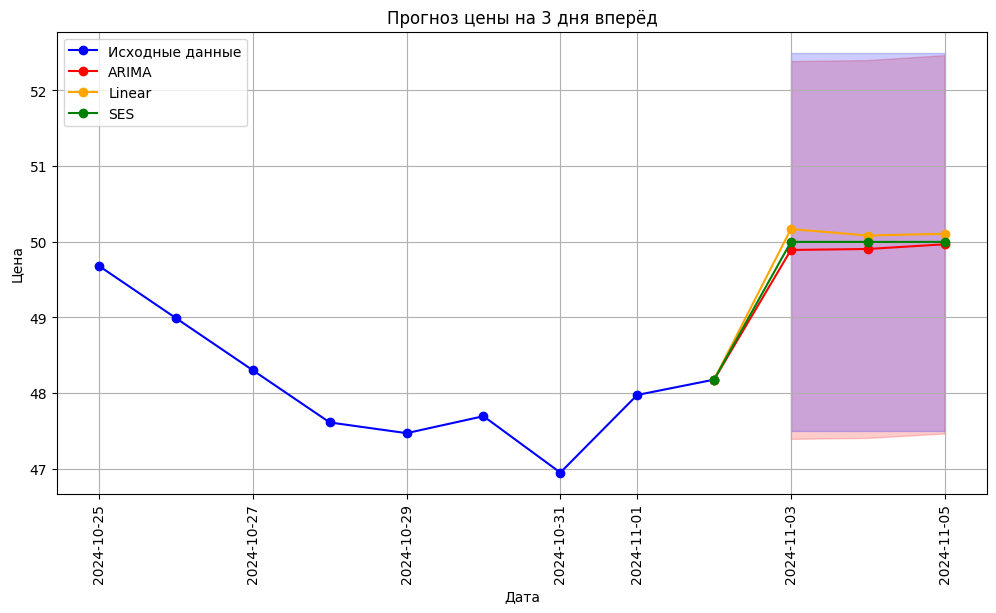


Обработка файла: datasets/сleaned\ASTR_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=2611.58)

Прогнозы для ASTR:
SES: [np.float64(529.022), np.float64(529.022), np.float64(529.022)]
ARIMA: [np.float64(528.15), np.float64(528.293), np.float64(528.159)]
Linear: [np.float64(533.71), np.float64(533.782), np.float64(534.241)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=10.431, MAPE=0.020, R2=-4.497
ARIMA: MAE=9.610, MAPE=0.019, R2=-3.819
Linear: MAE=15.320, MAPE=0.030, R2=-9.791

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=4.4070, MAPE=0.0084, R2=nan
  ARIMA: MAE=3.5358, MAPE=0.0067, R2=nan
  Linear: MAE=9.0950, MAPE=0.0173, R2=nan
День 2:
  SES:   MAE=10.4314, MAPE=0.0201, R2=nan
  ARIMA: MAE=9.7029, MAPE=0.0187, R2=nan
  Linear: MAE=15.1916, MAPE=0.0293, R2=nan
День 3:
  SES:   MAE=16.4557, MAPE=0.0321, R2=nan
  ARIMA: MAE=15.5928, MAPE=0.0304, R2=nan
  Linear: MAE=21.6746, MAPE=0.0423,

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


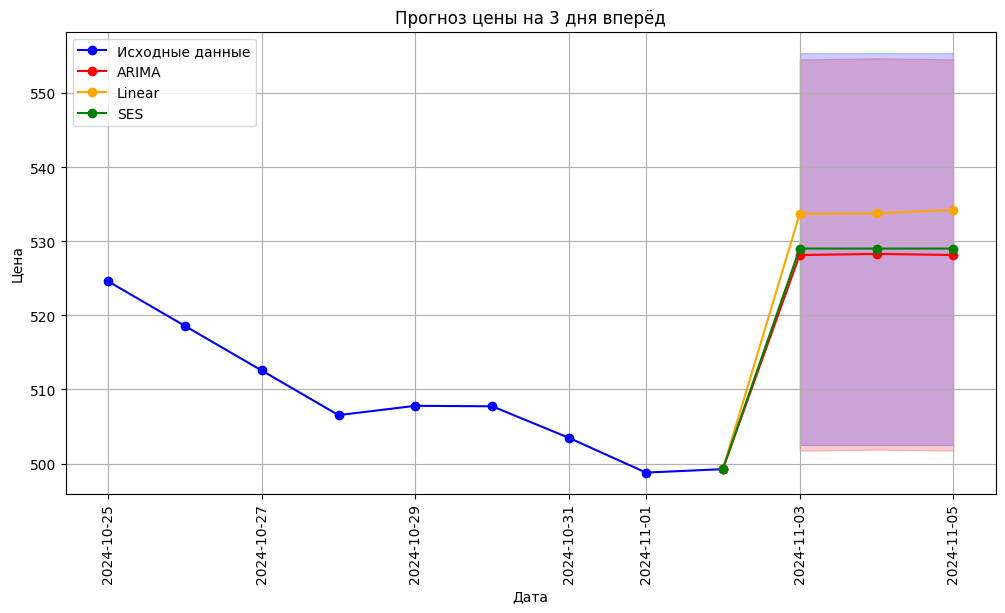


Обработка файла: datasets/сleaned\CHMF_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=9593.54)

Прогнозы для CHMF:
SES: [np.float64(1166.995), np.float64(1166.995), np.float64(1166.995)]
ARIMA: [np.float64(1163.8), np.float64(1162.964), np.float64(1162.513)]
Linear: [np.float64(1173.826), np.float64(1172.502), np.float64(1172.042)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=22.809, MAPE=0.020, R2=-3.755
ARIMA: MAE=18.907, MAPE=0.017, R2=-2.493
Linear: MAE=28.604, MAPE=0.025, R2=-5.786

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=8.3937, MAPE=0.0072, R2=nan
  ARIMA: MAE=5.1984, MAPE=0.0045, R2=nan
  Linear: MAE=15.2246, MAPE=0.0131, R2=nan
День 2:
  SES:   MAE=22.8094, MAPE=0.0199, R2=nan
  ARIMA: MAE=18.7782, MAPE=0.0164, R2=nan
  Linear: MAE=28.3162, MAPE=0.0247, R2=nan
День 3:
  SES:   MAE=37.2251, MAPE=0.0329, R2=nan
  ARIMA: MAE=32.7431, MAPE=0.0290, R2=nan
  Linear: MAE=42.2717, 

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


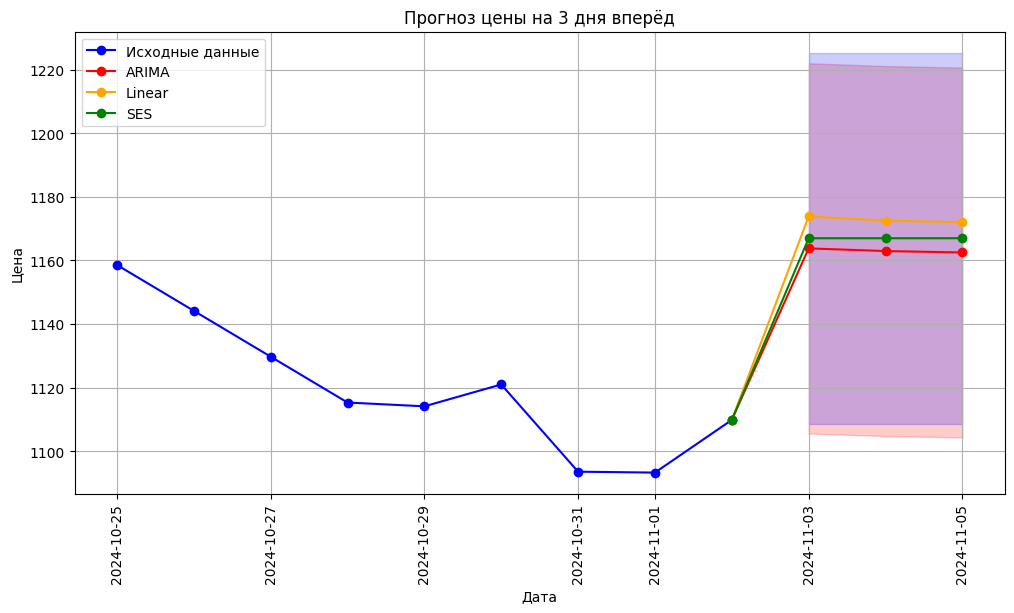


Обработка файла: datasets/сleaned\ENPG_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=8356.74)

Прогнозы для ENPG:
SES: [np.float64(330.837), np.float64(330.837), np.float64(330.837)]
ARIMA: [np.float64(330.315), np.float64(330.18), np.float64(330.129)]
Linear: [np.float64(333.043), np.float64(333.849), np.float64(334.538)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=5.438, MAPE=0.017, R2=-3.160
ARIMA: MAE=4.809, MAPE=0.015, R2=-2.423
Linear: MAE=8.411, MAPE=0.026, R2=-7.999

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.6917, MAPE=0.0051, R2=nan
  ARIMA: MAE=1.1701, MAPE=0.0036, R2=nan
  Linear: MAE=3.8971, MAPE=0.0118, R2=nan
День 2:
  SES:   MAE=5.4382, MAPE=0.0167, R2=nan
  ARIMA: MAE=4.7813, MAPE=0.0147, R2=nan
  Linear: MAE=8.4505, MAPE=0.0260, R2=nan
День 3:
  SES:   MAE=9.1846, MAPE=0.0286, R2=nan
  ARIMA: MAE=8.4762, MAPE=0.0264, R2=nan
  Linear: MAE=12.8852, MAPE=0.0401, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


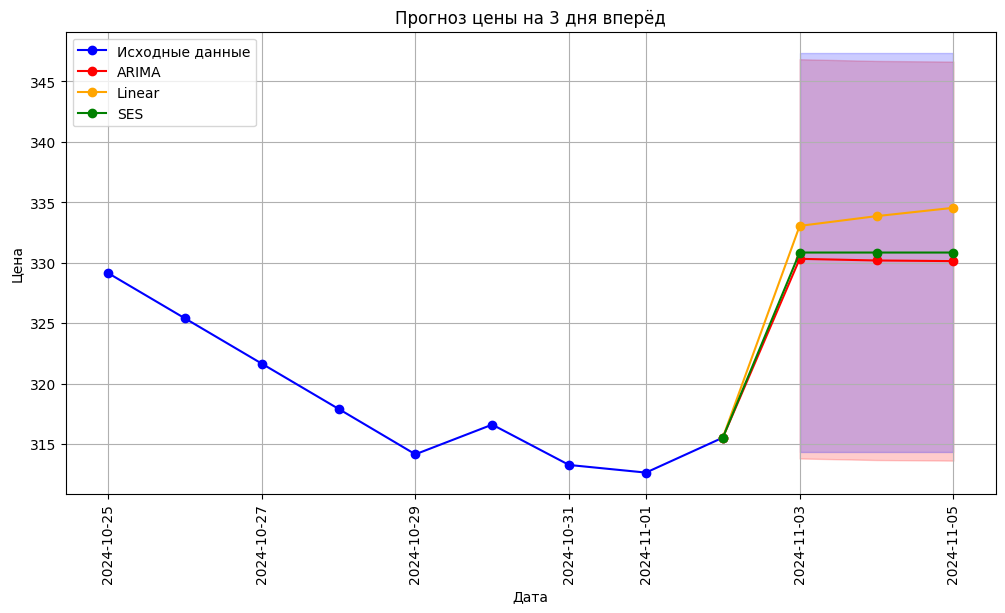


Обработка файла: datasets/сleaned\FEES_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Выбранные параметры ARIMA: p=2, d=0, q=2 (AIC=-11426.41)


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Прогнозы для FEES:
SES: [np.float64(0.078), np.float64(0.078), np.float64(0.078)]
ARIMA: [np.float64(0.078), np.float64(0.078), np.float64(0.078)]
Linear: [np.float64(0.079), np.float64(0.079), np.float64(0.079)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.001, MAPE=0.017, R2=-3.261
ARIMA: MAE=0.001, MAPE=0.013, R2=-1.736
Linear: MAE=0.002, MAPE=0.024, R2=-6.019

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.0004, MAPE=0.0055, R2=nan
  ARIMA: MAE=0.0001, MAPE=0.0010, R2=nan
  Linear: MAE=0.0011, MAPE=0.0136, R2=nan
День 2:
  SES:   MAE=0.0013, MAPE=0.0174, R2=nan
  ARIMA: MAE=0.0009, MAPE=0.0121, R2=nan
  Linear: MAE=0.0018, MAPE=0.0231, R2=nan
День 3:
  SES:   MAE=0.0022, MAPE=0.0295, R2=nan
  ARIMA: MAE=0.0019, MAPE=0.0250, R2=nan
  Linear: MAE=0.0027, MAPE=0.0354, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


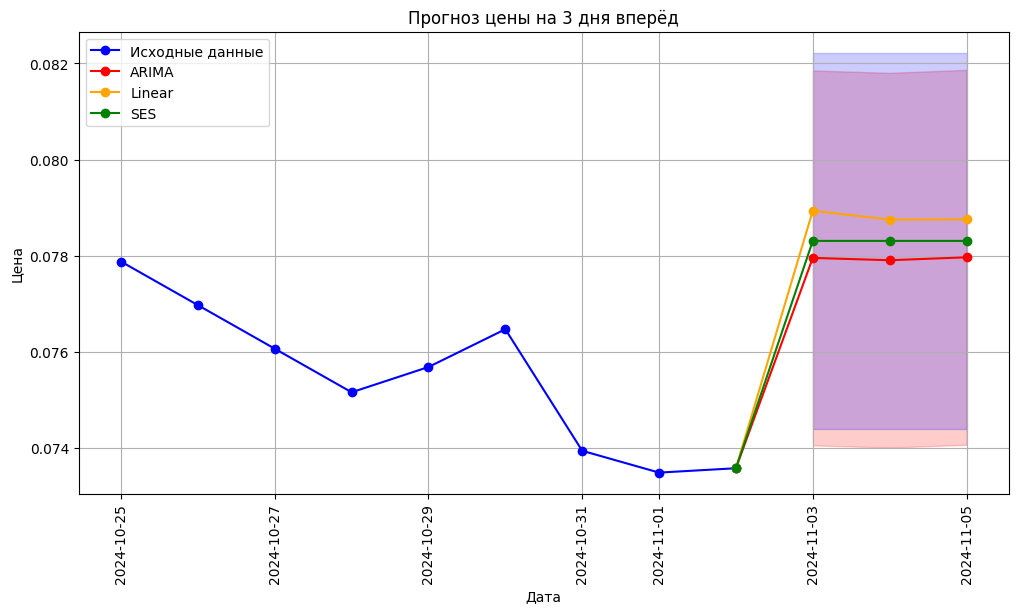


Обработка файла: datasets/сleaned\FIVE_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=8307.23)

Прогнозы для FIVE:
SES: [np.float64(2858.186), np.float64(2858.186), np.float64(2858.186)]
ARIMA: [np.float64(2861.357), np.float64(2862.892), np.float64(2863.644)]
Linear: [np.float64(2853.427), np.float64(2853.984), np.float64(2853.757)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=65.176, MAPE=0.022, R2=-15.875
ARIMA: MAE=60.732, MAPE=0.021, R2=-13.675
Linear: MAE=69.640, MAPE=0.024, R2=-18.109

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=46.0848, MAPE=0.0159, R2=nan
  ARIMA: MAE=42.9144, MAPE=0.0148, R2=nan
  Linear: MAE=50.8443, MAPE=0.0175, R2=nan
День 2:
  SES:   MAE=63.4067, MAPE=0.0217, R2=nan
  ARIMA: MAE=58.7013, MAPE=0.0201, R2=nan
  Linear: MAE=67.6088, MAPE=0.0231, R2=nan
День 3:
  SES:   MAE=86.0366, MAPE=0.0292, R2=nan
  ARIMA: MAE=80.5793, MAPE=0.0274, R2=nan
  Linear: MAE=90

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


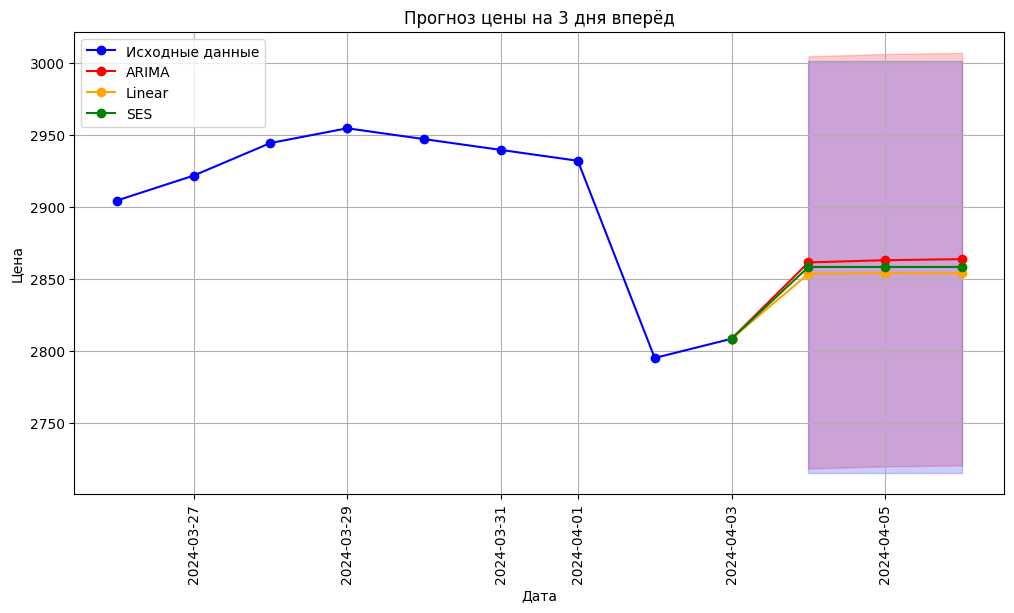


Обработка файла: datasets/сleaned\GAZP_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=6271.66)

Прогнозы для GAZP:
SES: [np.float64(133.759), np.float64(133.759), np.float64(133.759)]
ARIMA: [np.float64(133.012), np.float64(132.915), np.float64(132.869)]
Linear: [np.float64(135.686), np.float64(135.771), np.float64(135.946)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=2.010, MAPE=0.015, R2=-1.741
ARIMA: MAE=1.585, MAPE=0.012, R2=-0.528
Linear: MAE=4.053, MAPE=0.031, R2=-7.217

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.1442, MAPE=0.0011, R2=nan
  ARIMA: MAE=0.6027, MAPE=0.0045, R2=nan
  Linear: MAE=2.0714, MAPE=0.0155, R2=nan
День 2:
  SES:   MAE=2.0105, MAPE=0.0153, R2=nan
  ARIMA: MAE=1.1664, MAPE=0.0089, R2=nan
  Linear: MAE=4.0228, MAPE=0.0305, R2=nan
День 3:
  SES:   MAE=3.8767, MAPE=0.0298, R2=nan
  ARIMA: MAE=2.9871, MAPE=0.0230, R2=nan
  Linear: MAE=6.0636, MAPE=0.0467, R2=n

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


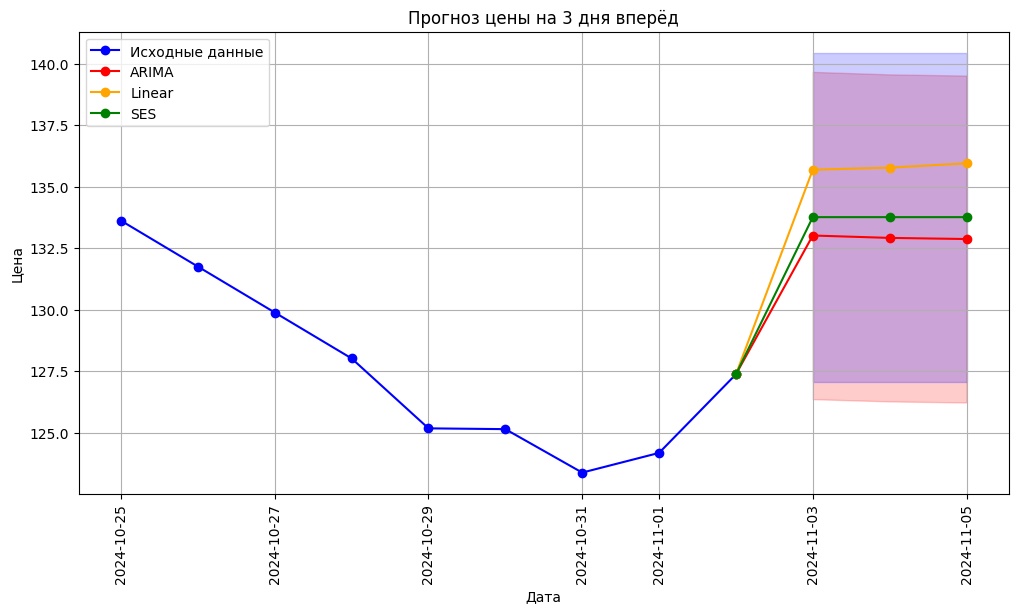


Обработка файла: datasets/сleaned\GMKN_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=4426.70)

Прогнозы для GMKN:
SES: [np.float64(104.946), np.float64(104.946), np.float64(104.946)]
ARIMA: [np.float64(104.812), np.float64(104.769), np.float64(104.738)]
Linear: [np.float64(105.455), np.float64(105.458), np.float64(105.488)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=3.067, MAPE=0.030, R2=-3.739
ARIMA: MAE=2.895, MAPE=0.029, R2=-3.293
Linear: MAE=3.588, MAPE=0.035, R2=-5.134

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.1245, MAPE=0.0108, R2=nan
  ARIMA: MAE=0.9912, MAPE=0.0095, R2=nan
  Linear: MAE=1.6337, MAPE=0.0157, R2=nan
День 2:
  SES:   MAE=3.0674, MAPE=0.0301, R2=nan
  ARIMA: MAE=2.8905, MAPE=0.0284, R2=nan
  Linear: MAE=3.5794, MAPE=0.0351, R2=nan
День 3:
  SES:   MAE=5.0102, MAPE=0.0501, R2=nan
  ARIMA: MAE=4.8031, MAPE=0.0481, R2=nan
  Linear: MAE=5.5522, MAPE=0.0556, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


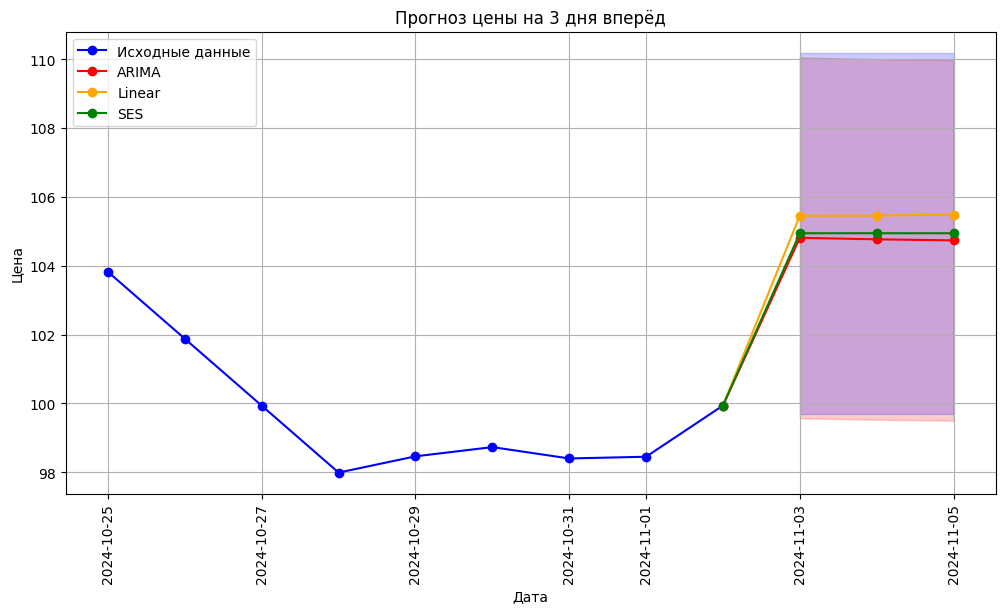


Обработка файла: datasets/сleaned\HYDR_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=-7754.02)

Прогнозы для HYDR:
SES: [np.float64(0.511), np.float64(0.511), np.float64(0.511)]
ARIMA: [np.float64(0.509), np.float64(0.509), np.float64(0.508)]
Linear: [np.float64(0.518), np.float64(0.518), np.float64(0.519)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.009, MAPE=0.019, R2=-5.131
ARIMA: MAE=0.006, MAPE=0.013, R2=-2.097
Linear: MAE=0.016, MAPE=0.033, R2=-16.059

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.0043, MAPE=0.0085, R2=nan
  ARIMA: MAE=0.0018, MAPE=0.0036, R2=nan
  Linear: MAE=0.0109, MAPE=0.0215, R2=nan
День 2:
  SES:   MAE=0.0094, MAPE=0.0186, R2=nan
  ARIMA: MAE=0.0065, MAPE=0.0130, R2=nan
  Linear: MAE=0.0164, MAPE=0.0327, R2=nan
День 3:
  SES:   MAE=0.0144, MAPE=0.0290, R2=nan
  ARIMA: MAE=0.0106, MAPE=0.0213, R2=nan
  Linear: MAE=0.0220, MAPE=0.0443, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


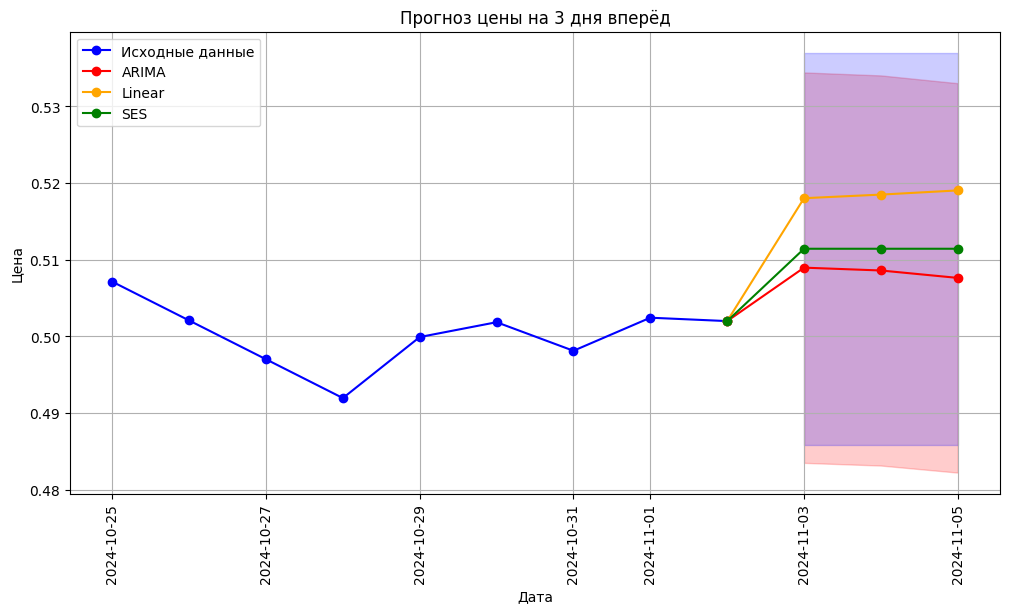


Обработка файла: datasets/сleaned\IRAO_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=-3893.38)

Прогнозы для IRAO:
SES: [np.float64(3.753), np.float64(3.753), np.float64(3.753)]
ARIMA: [np.float64(3.74), np.float64(3.735), np.float64(3.733)]
Linear: [np.float64(3.778), np.float64(3.773), np.float64(3.771)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.016, MAPE=0.004, R2=-18.879
ARIMA: MAE=0.033, MAPE=0.009, R2=-77.623
Linear: MAE=0.005, MAPE=0.001, R2=-0.507

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.0210, MAPE=0.0056, R2=nan
  ARIMA: MAE=0.0340, MAPE=0.0090, R2=nan
  Linear: MAE=0.0039, MAPE=0.0010, R2=nan
День 2:
  SES:   MAE=0.0164, MAPE=0.0043, R2=nan
  ARIMA: MAE=0.0345, MAPE=0.0091, R2=nan
  Linear: MAE=0.0037, MAPE=0.0010, R2=nan
День 3:
  SES:   MAE=0.0118, MAPE=0.0031, R2=nan
  ARIMA: MAE=0.0318, MAPE=0.0084, R2=nan
  Linear: MAE=0.0060, MAPE=0.0016, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


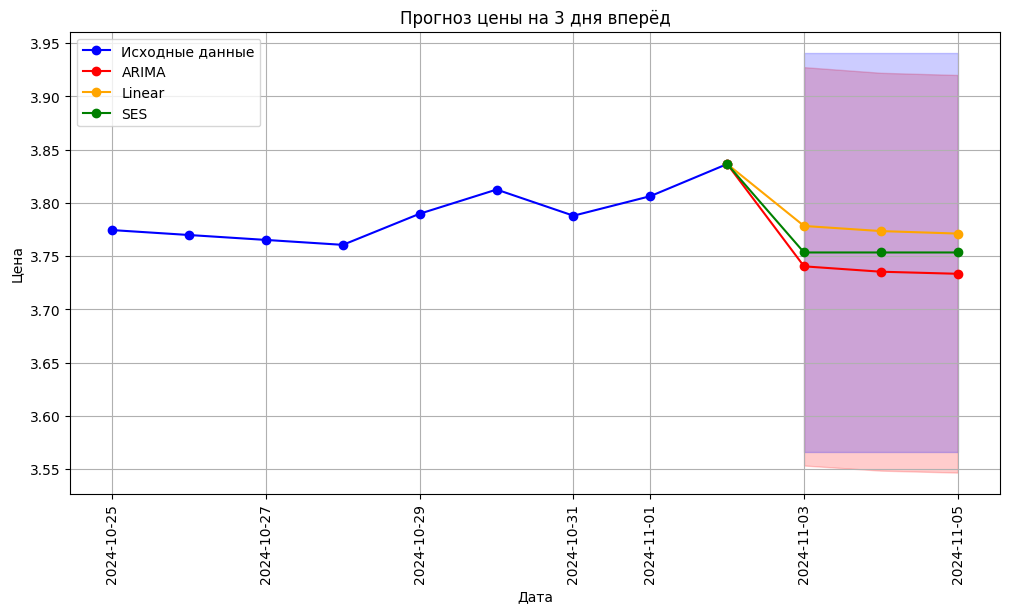


Обработка файла: datasets/сleaned\LEAS_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=1563.84)

Прогнозы для LEAS:
SES: [np.float64(650.548), np.float64(650.548), np.float64(650.548)]
ARIMA: [np.float64(645.852), np.float64(644.582), np.float64(644.238)]
Linear: [np.float64(663.31), np.float64(661.081), np.float64(659.327)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=33.519, MAPE=0.055, R2=-7.826
ARIMA: MAE=27.862, MAPE=0.046, R2=-5.300
Linear: MAE=44.210, MAPE=0.072, R2=-13.361

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=18.8445, MAPE=0.0298, R2=nan
  ARIMA: MAE=14.1484, MAPE=0.0224, R2=nan
  Linear: MAE=31.6061, MAPE=0.0500, R2=nan
День 2:
  SES:   MAE=33.5193, MAPE=0.0543, R2=nan
  ARIMA: MAE=27.5529, MAPE=0.0447, R2=nan
  Linear: MAE=44.0521, MAPE=0.0714, R2=nan
День 3:
  SES:   MAE=48.1941, MAPE=0.0800, R2=nan
  ARIMA: MAE=41.8840, MAPE=0.0695, R2=nan
  Linear: MAE=56.9729, MAPE=

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


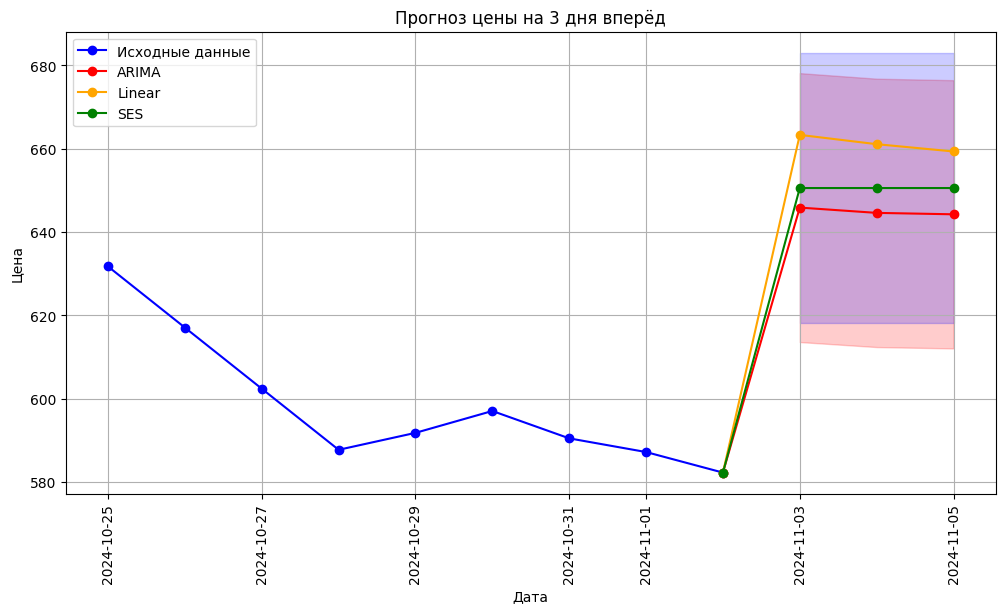


Обработка файла: datasets/сleaned\MGNT_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=12587.87)

Прогнозы для MGNT:
SES: [np.float64(4678.607), np.float64(4678.607), np.float64(4678.607)]
ARIMA: [np.float64(4646.784), np.float64(4630.787), np.float64(4621.637)]
Linear: [np.float64(4731.159), np.float64(4722.547), np.float64(4720.591)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=140.590, MAPE=0.031, R2=-4.975
ARIMA: MAE=95.052, MAPE=0.021, R2=-1.976
Linear: MAE=186.748, MAPE=0.041, R2=-8.647

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=63.3946, MAPE=0.0137, R2=nan
  ARIMA: MAE=31.5711, MAPE=0.0068, R2=nan
  Linear: MAE=115.9459, MAPE=0.0251, R2=nan
День 2:
  SES:   MAE=140.5900, MAPE=0.0310, R2=nan
  ARIMA: MAE=92.7702, MAPE=0.0204, R2=nan
  Linear: MAE=184.5299, MAPE=0.0407, R2=nan
День 3:
  SES:   MAE=217.7854, MAPE=0.0488, R2=nan
  ARIMA: MAE=160.8147, MAPE=0.0361, R2=nan
  Linear: M

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


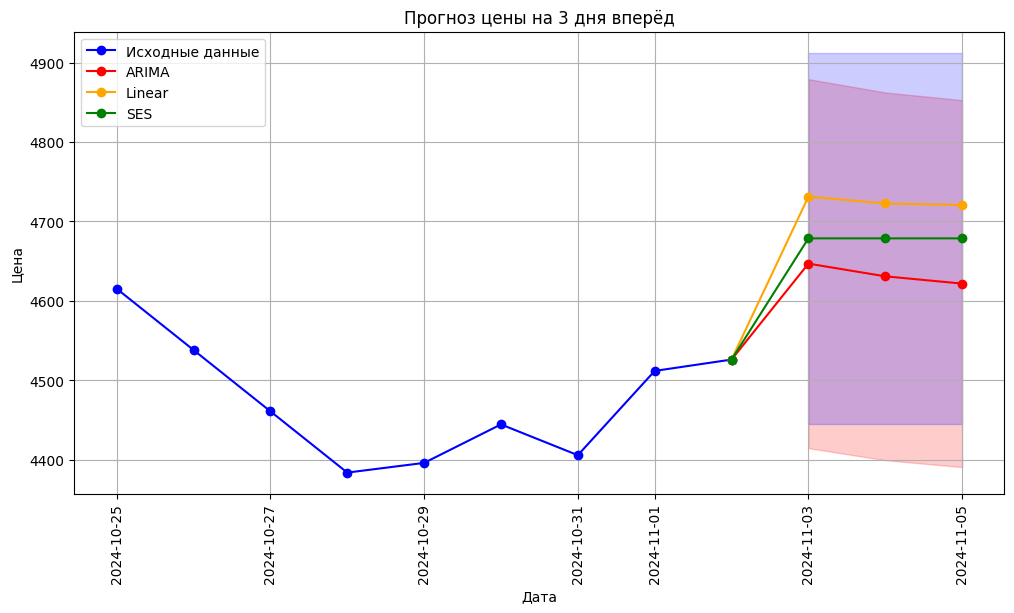


Обработка файла: datasets/сleaned\MOEX_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=4284.03)

Прогнозы для MOEX:
SES: [np.float64(199.979), np.float64(199.979), np.float64(199.979)]
ARIMA: [np.float64(199.293), np.float64(199.085), np.float64(199.024)]
Linear: [np.float64(201.299), np.float64(201.027), np.float64(200.928)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=1.467, MAPE=0.007, R2=-0.053
ARIMA: MAE=1.423, MAPE=0.007, R2=0.048
Linear: MAE=1.693, MAPE=0.009, R2=-0.641

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.6331, MAPE=0.0081, R2=nan
  ARIMA: MAE=2.3188, MAPE=0.0115, R2=nan
  Linear: MAE=0.3133, MAPE=0.0016, R2=nan
День 2:
  SES:   MAE=0.3785, MAPE=0.0019, R2=nan
  ARIMA: MAE=0.5151, MAPE=0.0026, R2=nan
  Linear: MAE=1.4269, MAPE=0.0071, R2=nan
День 3:
  SES:   MAE=2.3900, MAPE=0.0121, R2=nan
  ARIMA: MAE=1.4347, MAPE=0.0073, R2=nan
  Linear: MAE=3.3391, MAPE=0.0169, R2=na

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


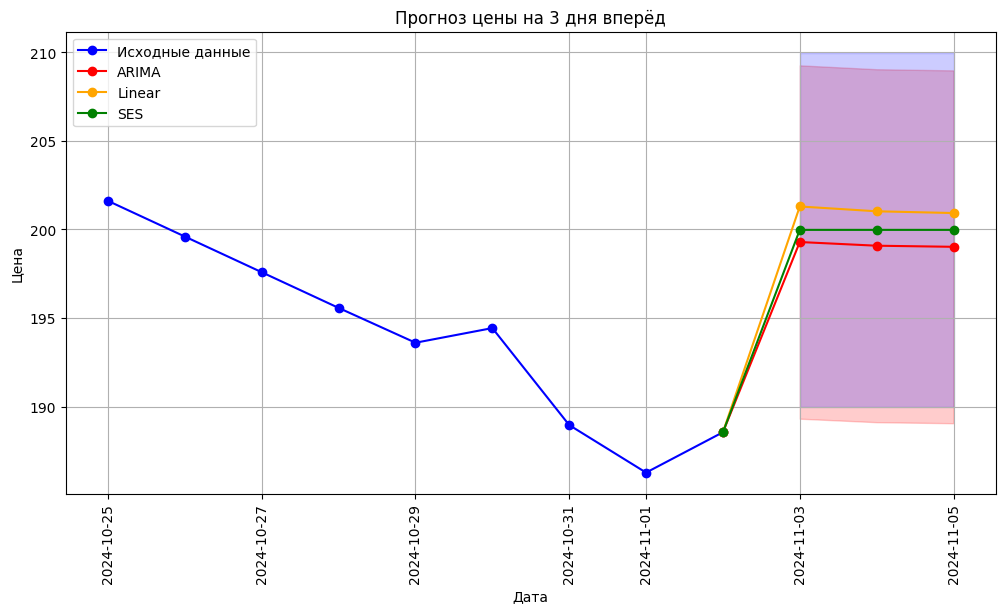


Обработка файла: datasets/сleaned\MSNG_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=-4465.03)

Прогнозы для MSNG:
SES: [np.float64(2.307), np.float64(2.307), np.float64(2.307)]
ARIMA: [np.float64(2.3), np.float64(2.301), np.float64(2.301)]
Linear: [np.float64(2.326), np.float64(2.325), np.float64(2.326)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.015, MAPE=0.007, R2=-0.369
ARIMA: MAE=0.013, MAPE=0.006, R2=-0.079
Linear: MAE=0.028, MAPE=0.012, R2=-3.655

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.0090, MAPE=0.0039, R2=nan
  ARIMA: MAE=0.0151, MAPE=0.0065, R2=nan
  Linear: MAE=0.0103, MAPE=0.0045, R2=nan
День 2:
  SES:   MAE=0.0089, MAPE=0.0039, R2=nan
  ARIMA: MAE=0.0037, MAPE=0.0016, R2=nan
  Linear: MAE=0.0279, MAPE=0.0121, R2=nan
День 3:
  SES:   MAE=0.0268, MAPE=0.0118, R2=nan
  ARIMA: MAE=0.0212, MAPE=0.0093, R2=nan
  Linear: MAE=0.0459, MAPE=0.0201, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


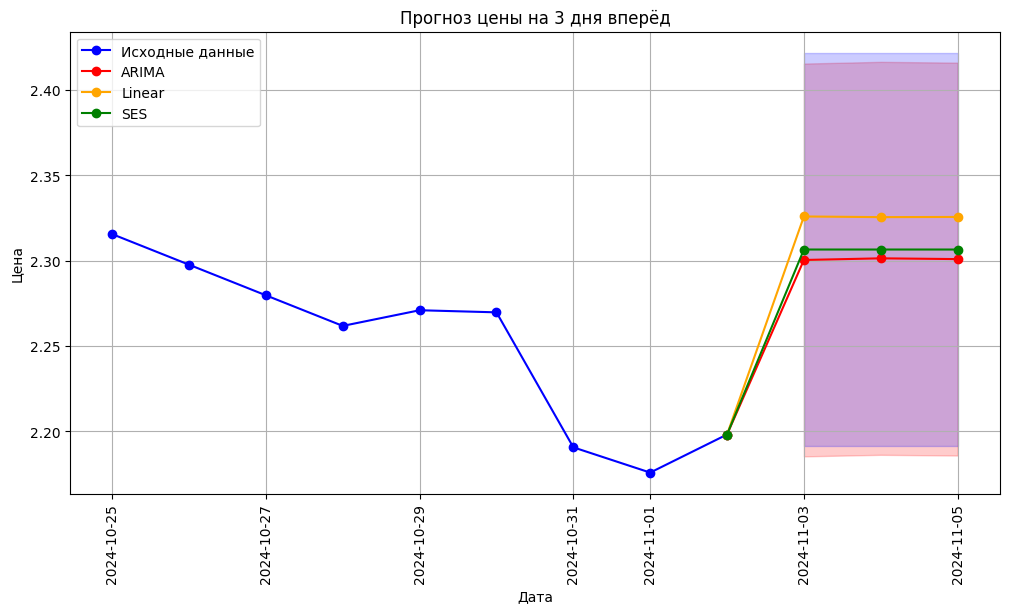


Обработка файла: datasets/сleaned\MTLRP_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=6584.67)

Прогнозы для MTLRP:
SES: [np.float64(106.065), np.float64(106.065), np.float64(106.065)]
ARIMA: [np.float64(105.618), np.float64(105.487), np.float64(105.449)]
Linear: [np.float64(107.017), np.float64(107.003), np.float64(107.137)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=2.915, MAPE=0.028, R2=-7.294
ARIMA: MAE=2.368, MAPE=0.023, R2=-4.690
Linear: MAE=3.902, MAPE=0.038, R2=-13.167

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.5929, MAPE=0.0152, R2=nan
  ARIMA: MAE=1.1458, MAPE=0.0110, R2=nan
  Linear: MAE=2.5449, MAPE=0.0244, R2=nan
День 2:
  SES:   MAE=2.9146, MAPE=0.0283, R2=nan
  ARIMA: MAE=2.3368, MAPE=0.0227, R2=nan
  Linear: MAE=3.8522, MAPE=0.0373, R2=nan
День 3:
  SES:   MAE=4.2363, MAPE=0.0416, R2=nan
  ARIMA: MAE=3.6202, MAPE=0.0356, R2=nan
  Linear: MAE=5.3084, MAPE=0.0521, R

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


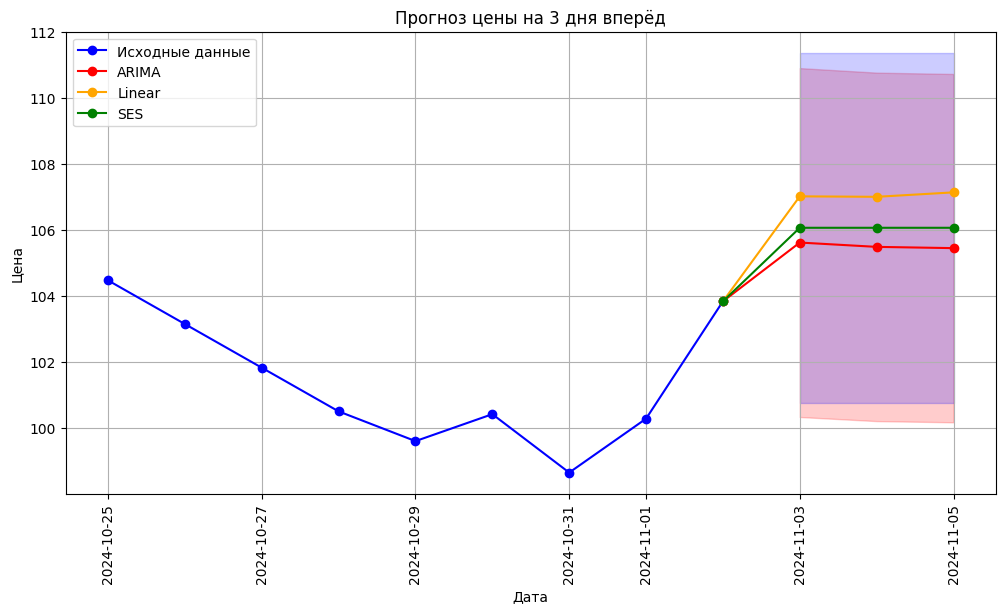


Обработка файла: datasets/сleaned\MTLR_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=5737.12)

Прогнозы для MTLR:
SES: [np.float64(103.955), np.float64(103.955), np.float64(103.955)]
ARIMA: [np.float64(103.496), np.float64(103.288), np.float64(103.112)]
Linear: [np.float64(104.756), np.float64(104.526), np.float64(104.503)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=2.589, MAPE=0.026, R2=-6.677
ARIMA: MAE=1.932, MAPE=0.019, R2=-3.433
Linear: MAE=3.228, MAPE=0.032, R2=-10.193

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.3617, MAPE=0.0133, R2=nan
  ARIMA: MAE=0.9030, MAPE=0.0088, R2=nan
  Linear: MAE=2.1624, MAPE=0.0211, R2=nan
День 2:
  SES:   MAE=2.5887, MAPE=0.0255, R2=nan
  ARIMA: MAE=1.9212, MAPE=0.0190, R2=nan
  Linear: MAE=3.1593, MAPE=0.0312, R2=nan
День 3:
  SES:   MAE=3.8156, MAPE=0.0381, R2=nan
  ARIMA: MAE=2.9730, MAPE=0.0297, R2=nan
  Linear: MAE=4.3635, MAPE=0.0436, R2=

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


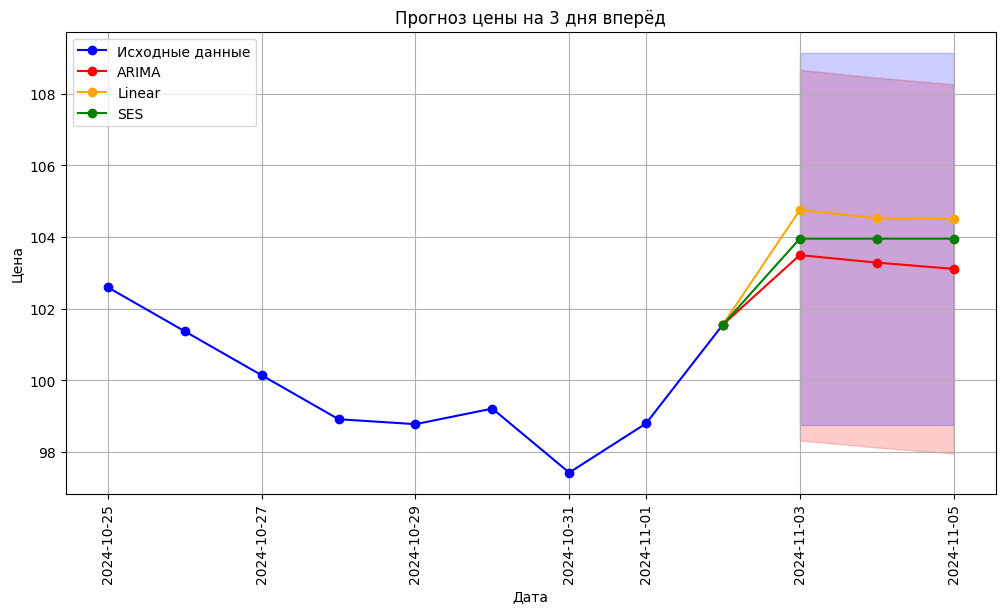


Обработка файла: datasets/сleaned\MTSS_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=5778.60)

Прогнозы для MTSS:
SES: [np.float64(197.3), np.float64(197.3), np.float64(197.3)]
ARIMA: [np.float64(196.914), np.float64(196.8), np.float64(196.767)]
Linear: [np.float64(197.262), np.float64(197.098), np.float64(197.339)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=3.626, MAPE=0.019, R2=-4.358
ARIMA: MAE=3.153, MAPE=0.016, R2=-3.228
Linear: MAE=3.559, MAPE=0.018, R2=-4.238

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.4986, MAPE=0.0077, R2=nan
  ARIMA: MAE=1.1121, MAPE=0.0057, R2=nan
  Linear: MAE=1.4607, MAPE=0.0075, R2=nan
День 2:
  SES:   MAE=3.6260, MAPE=0.0187, R2=nan
  ARIMA: MAE=3.1264, MAPE=0.0161, R2=nan
  Linear: MAE=3.4244, MAPE=0.0177, R2=nan
День 3:
  SES:   MAE=5.7533, MAPE=0.0300, R2=nan
  ARIMA: MAE=5.2208, MAPE=0.0273, R2=nan
  Linear: MAE=5.7923, MAPE=0.0302, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


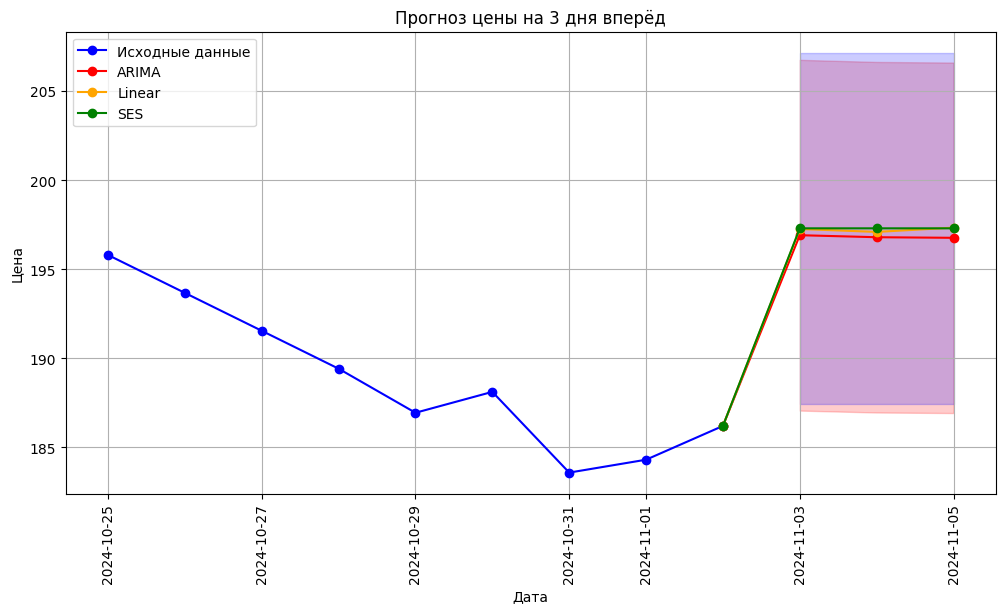


Обработка файла: datasets/сleaned\NVTK_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=9369.46)

Прогнозы для NVTK:
SES: [np.float64(920.694), np.float64(920.694), np.float64(920.694)]
ARIMA: [np.float64(913.921), np.float64(910.948), np.float64(909.623)]
Linear: [np.float64(934.433), np.float64(933.264), np.float64(933.537)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=17.914, MAPE=0.020, R2=-4.159
ARIMA: MAE=8.717, MAPE=0.010, R2=-0.627
Linear: MAE=30.965, MAPE=0.034, R2=-12.344

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=7.1552, MAPE=0.0078, R2=nan
  ARIMA: MAE=0.3819, MAPE=0.0004, R2=nan
  Linear: MAE=20.8934, MAPE=0.0229, R2=nan
День 2:
  SES:   MAE=17.9143, MAPE=0.0198, R2=nan
  ARIMA: MAE=8.1675, MAPE=0.0090, R2=nan
  Linear: MAE=30.4841, MAPE=0.0338, R2=nan
День 3:
  SES:   MAE=28.6734, MAPE=0.0321, R2=nan
  ARIMA: MAE=17.6019, MAPE=0.0197, R2=nan
  Linear: MAE=41.5163, MAPE=0.0

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


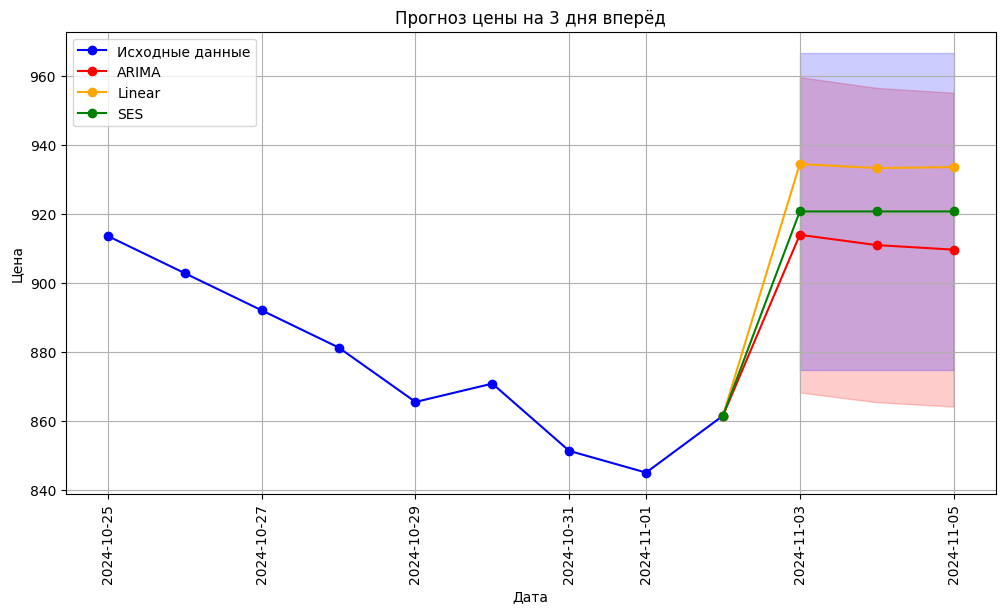


Обработка файла: datasets/сleaned\OZON_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=11349.06)

Прогнозы для OZON:
SES: [np.float64(2996.124), np.float64(2996.124), np.float64(2996.124)]
ARIMA: [np.float64(2994.955), np.float64(2994.568), np.float64(2994.396)]
Linear: [np.float64(2988.853), np.float64(2984.456), np.float64(2981.644)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=106.551, MAPE=0.037, R2=-4.444
ARIMA: MAE=105.067, MAPE=0.037, R2=-4.312
Linear: MAE=95.411, MAPE=0.033, R2=-3.451

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=44.6495, MAPE=0.0151, R2=nan
  ARIMA: MAE=43.4810, MAPE=0.0147, R2=nan
  Linear: MAE=37.3787, MAPE=0.0127, R2=nan
День 2:
  SES:   MAE=106.5506, MAPE=0.0369, R2=nan
  ARIMA: MAE=104.9951, MAPE=0.0363, R2=nan
  Linear: MAE=94.8824, MAPE=0.0328, R2=nan
День 3:
  SES:   MAE=168.4517, MAPE=0.0596, R2=nan
  ARIMA: MAE=166.7244, MAPE=0.0590, R2=nan
  Linear: MA

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


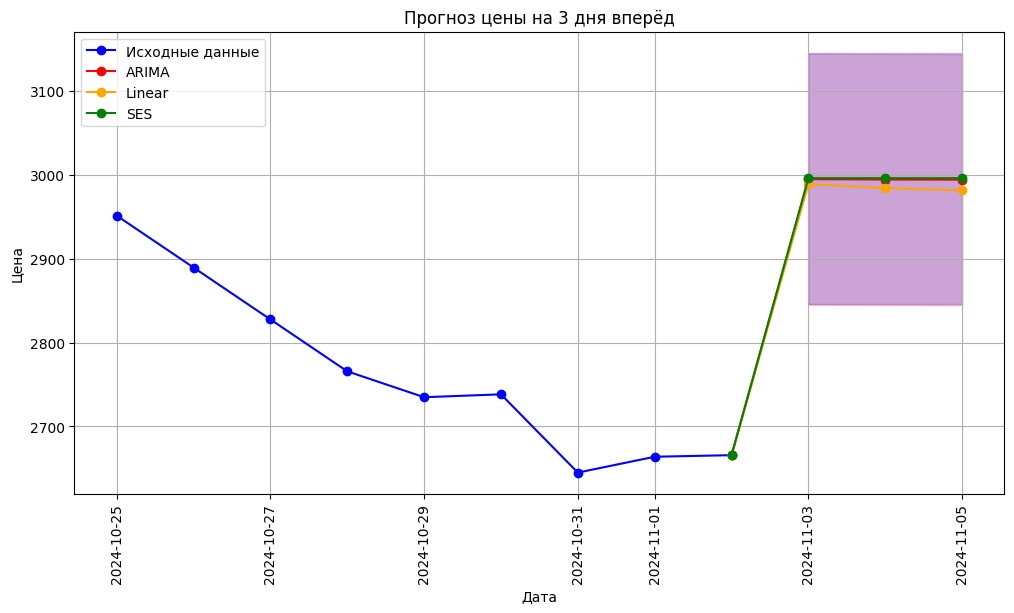


Обработка файла: datasets/сleaned\PLZL_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=14168.75)

Прогнозы для PLZL:
SES: [np.float64(14638.462), np.float64(14638.462), np.float64(14638.462)]
ARIMA: [np.float64(14668.705), np.float64(14687.632), np.float64(14700.802)]
Linear: [np.float64(14648.375), np.float64(14644.272), np.float64(14636.364)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=61.200, MAPE=0.004, R2=-0.470
ARIMA: MAE=88.289, MAPE=0.006, R2=-2.725
Linear: MAE=59.133, MAPE=0.004, R2=-0.422

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=31.5859, MAPE=0.0022, R2=nan
  ARIMA: MAE=1.3431, MAPE=0.0001, R2=nan
  Linear: MAE=21.6728, MAPE=0.0015, R2=nan
День 2:
  SES:   MAE=40.1430, MAPE=0.0027, R2=nan
  ARIMA: MAE=89.3123, MAPE=0.0061, R2=nan
  Linear: MAE=45.9526, MAPE=0.0031, R2=nan
День 3:
  SES:   MAE=111.8719, MAPE=0.0077, R2=nan
  ARIMA: MAE=174.2119, MAPE=0.0120, R2=nan
  Linear

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


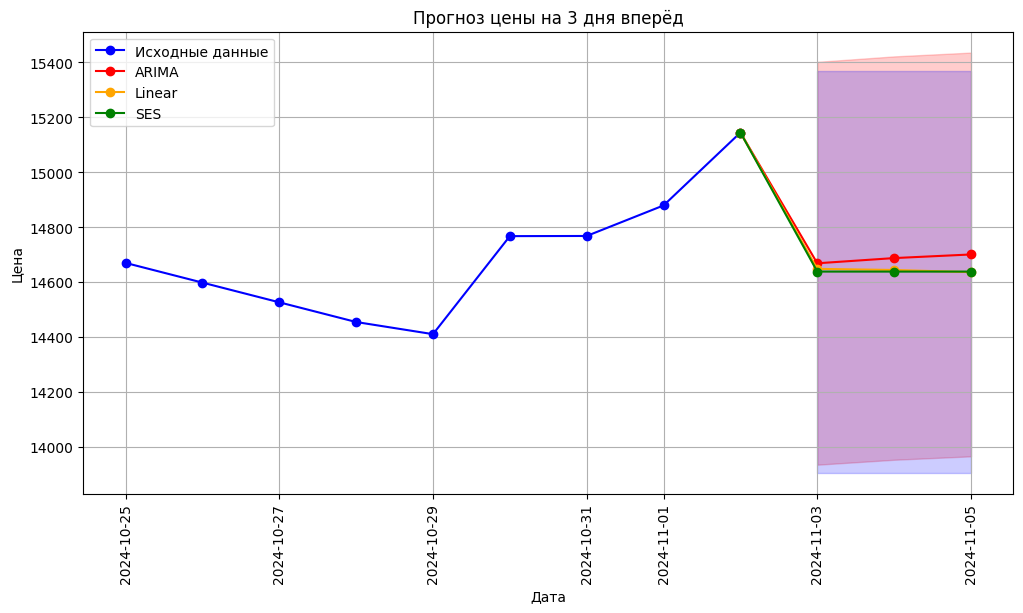


Обработка файла: datasets/сleaned\POSI_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=9555.51)

Прогнозы для POSI:
SES: [np.float64(2581.798), np.float64(2581.798), np.float64(2581.798)]
ARIMA: [np.float64(2578.221), np.float64(2581.397), np.float64(2578.2)]
Linear: [np.float64(2580.278), np.float64(2581.08), np.float64(2581.921)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=85.377, MAPE=0.034, R2=-4.156
ARIMA: MAE=82.852, MAPE=0.033, R2=-3.915
Linear: MAE=84.672, MAPE=0.034, R2=-4.120

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=34.0858, MAPE=0.0134, R2=nan
  ARIMA: MAE=30.5095, MAPE=0.0120, R2=nan
  Linear: MAE=32.5659, MAPE=0.0128, R2=nan
День 2:
  SES:   MAE=85.3769, MAPE=0.0342, R2=nan
  ARIMA: MAE=84.9762, MAPE=0.0340, R2=nan
  Linear: MAE=84.6592, MAPE=0.0339, R2=nan
День 3:
  SES:   MAE=136.6680, MAPE=0.0559, R2=nan
  ARIMA: MAE=133.0708, MAPE=0.0544, R2=nan
  Linear: MAE=136.79

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


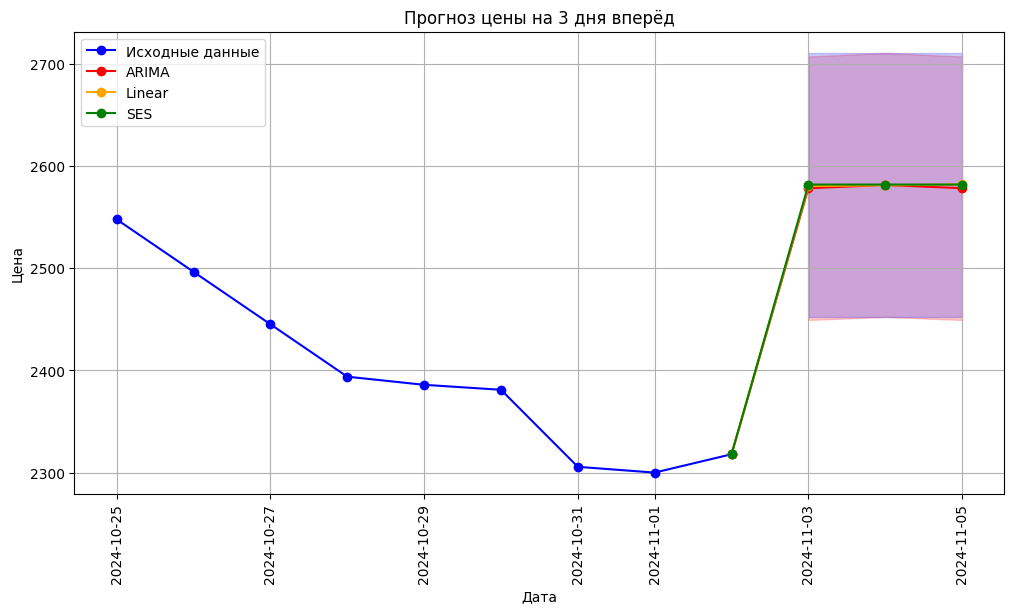


Обработка файла: datasets/сleaned\RTKM_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=2663.98)

Прогнозы для RTKM:
SES: [np.float64(68.131), np.float64(68.131), np.float64(68.131)]
ARIMA: [np.float64(67.683), np.float64(67.538), np.float64(67.491)]
Linear: [np.float64(69.389), np.float64(69.295), np.float64(69.266)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=2.276, MAPE=0.035, R2=-3.561
ARIMA: MAE=1.716, MAPE=0.026, R2=-1.898
Linear: MAE=3.462, MAPE=0.053, R2=-8.156

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.7990, MAPE=0.0119, R2=nan
  ARIMA: MAE=0.3515, MAPE=0.0052, R2=nan
  Linear: MAE=2.0570, MAPE=0.0305, R2=nan
День 2:
  SES:   MAE=2.2764, MAPE=0.0346, R2=nan
  ARIMA: MAE=1.6835, MAPE=0.0256, R2=nan
  Linear: MAE=3.4408, MAPE=0.0522, R2=nan
День 3:
  SES:   MAE=3.7538, MAPE=0.0583, R2=nan
  ARIMA: MAE=3.1136, MAPE=0.0484, R2=nan
  Linear: MAE=4.8888, MAPE=0.0759, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


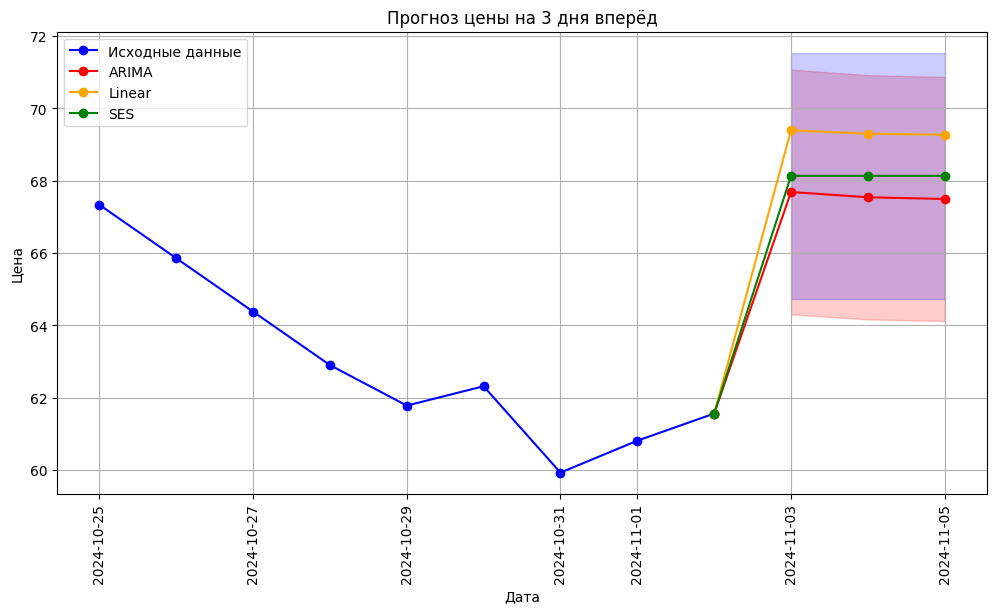


Обработка файла: datasets/сleaned\RUAL_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Выбранные параметры ARIMA: p=2, d=1, q=1 (AIC=2341.28)

Прогнозы для RUAL:
SES: [np.float64(34.653), np.float64(34.653), np.float64(34.653)]
ARIMA: [np.float64(34.569), np.float64(34.541), np.float64(34.534)]
Linear: [np.float64(34.969), np.float64(35.065), np.float64(35.117)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.563, MAPE=0.017, R2=-4.069
ARIMA: MAE=0.458, MAPE=0.014, R2=-2.600
Linear: MAE=0.960, MAPE=0.028, R2=-12.337

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.2210, MAPE=0.0064, R2=nan
  ARIMA: MAE=0.1372, MAPE=0.0040, R2=nan
  Linear: MAE=0.5375, MAPE=0.0156, R2=nan
День 2:
  SES:   MAE=0.5626, MAPE=0.0165, R2=nan
  ARIMA: MAE=0.4508, MAPE=0.0132, R2=nan
  Linear: MAE=0.9747, MAPE=0.0286, R2=nan
День 3:
  SES:   MAE=0.9042, MAPE=0.0268, R2=nan
  ARIMA: MAE=0.7862, MAPE=0.0233, R2=nan
  Linear: MAE=1.3688, MAPE=0.0406, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


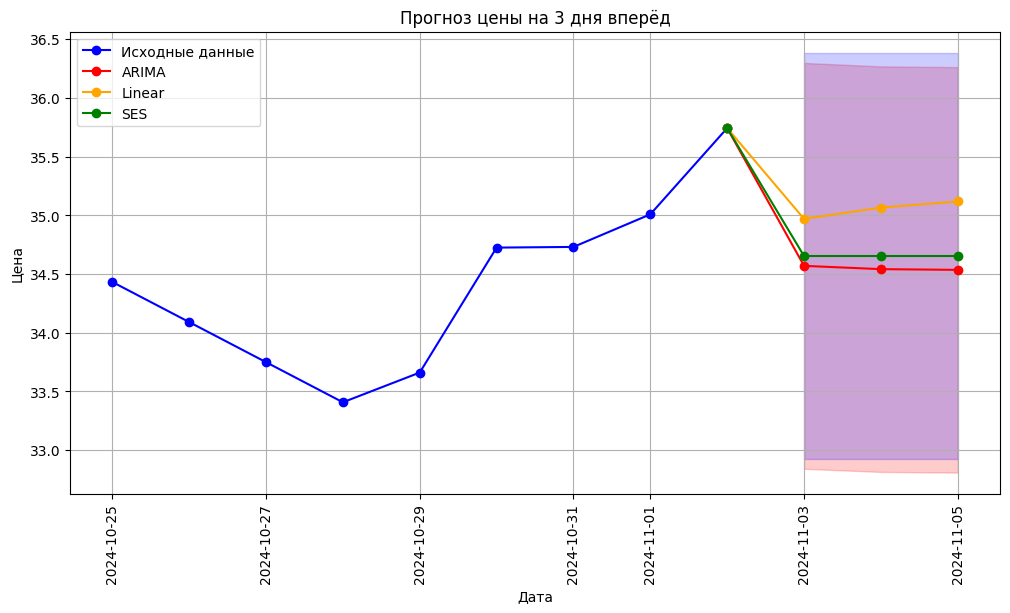


Обработка файла: datasets/сleaned\SBER_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=5419.94)

Прогнозы для SBER:
SES: [np.float64(251.902), np.float64(251.902), np.float64(251.902)]
ARIMA: [np.float64(251.09), np.float64(250.702), np.float64(250.517)]
Linear: [np.float64(252.161), np.float64(251.381), np.float64(250.92)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=3.657, MAPE=0.015, R2=-5.531
ARIMA: MAE=2.525, MAPE=0.010, R2=-2.359
Linear: MAE=3.242, MAPE=0.013, R2=-3.804

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=1.7527, MAPE=0.0070, R2=nan
  ARIMA: MAE=0.9405, MAPE=0.0038, R2=nan
  Linear: MAE=2.0108, MAPE=0.0080, R2=nan
День 2:
  SES:   MAE=3.6572, MAPE=0.0147, R2=nan
  ARIMA: MAE=2.4573, MAPE=0.0099, R2=nan
  Linear: MAE=3.1355, MAPE=0.0126, R2=nan
День 3:
  SES:   MAE=5.5617, MAPE=0.0226, R2=nan
  ARIMA: MAE=4.1767, MAPE=0.0170, R2=nan
  Linear: MAE=4.5797, MAPE=0.0186, R2=nan

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


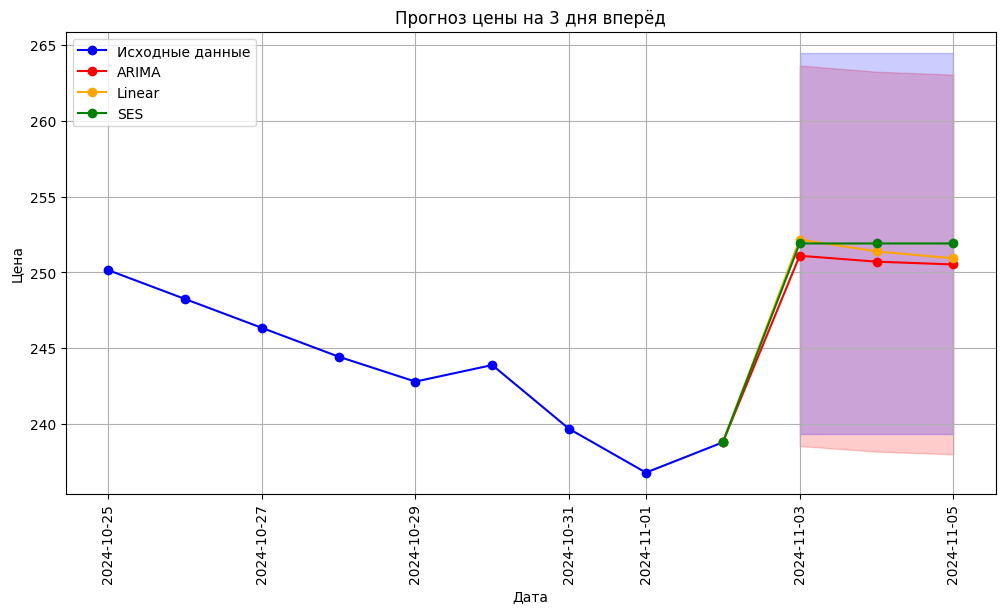


Обработка файла: datasets/сleaned\SELG_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=3017.24)

Прогнозы для SELG:
SES: [np.float64(48.857), np.float64(48.857), np.float64(48.857)]
ARIMA: [np.float64(48.421), np.float64(48.312), np.float64(48.284)]
Linear: [np.float64(50.162), np.float64(50.098), np.float64(50.109)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=1.650, MAPE=0.035, R2=-5.614
ARIMA: MAE=1.132, MAPE=0.024, R2=-2.489
Linear: MAE=2.916, MAPE=0.062, R2=-17.468

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.7972, MAPE=0.0166, R2=nan
  ARIMA: MAE=0.3612, MAPE=0.0075, R2=nan
  Linear: MAE=2.1016, MAPE=0.0437, R2=nan
День 2:
  SES:   MAE=1.6502, MAPE=0.0350, R2=nan
  ARIMA: MAE=1.1047, MAPE=0.0234, R2=nan
  Linear: MAE=2.8907, MAPE=0.0612, R2=nan
День 3:
  SES:   MAE=2.5032, MAPE=0.0540, R2=nan
  ARIMA: MAE=1.9302, MAPE=0.0416, R2=nan
  Linear: MAE=3.7551, MAPE=0.0810, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


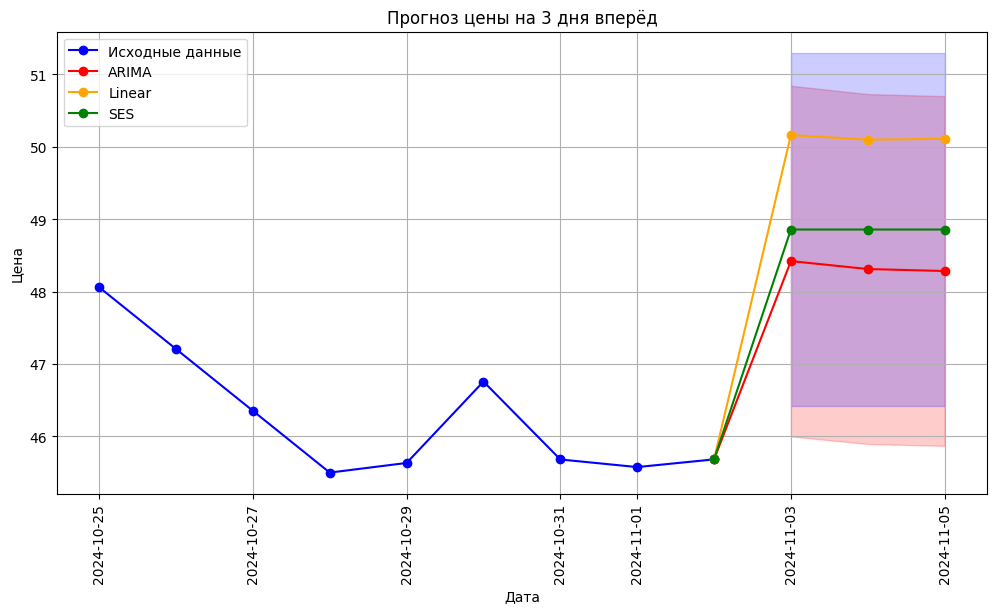


Обработка файла: datasets/сleaned\SNGS_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=1610.68)

Прогнозы для SNGS:
SES: [np.float64(24.016), np.float64(24.016), np.float64(24.016)]
ARIMA: [np.float64(23.894), np.float64(23.857), np.float64(23.846)]
Linear: [np.float64(24.349), np.float64(24.338), np.float64(24.351)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.455, MAPE=0.019, R2=-4.297
ARIMA: MAE=0.305, MAPE=0.013, R2=-1.764
Linear: MAE=0.785, MAPE=0.033, R2=-12.833

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.1860, MAPE=0.0078, R2=nan
  ARIMA: MAE=0.0648, MAPE=0.0027, R2=nan
  Linear: MAE=0.5192, MAPE=0.0218, R2=nan
День 2:
  SES:   MAE=0.4545, MAPE=0.0193, R2=nan
  ARIMA: MAE=0.2964, MAPE=0.0126, R2=nan
  Linear: MAE=0.7774, MAPE=0.0330, R2=nan
День 3:
  SES:   MAE=0.7231, MAPE=0.0310, R2=nan
  ARIMA: MAE=0.5537, MAPE=0.0238, R2=nan
  Linear: MAE=1.0588, MAPE=0.0455, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


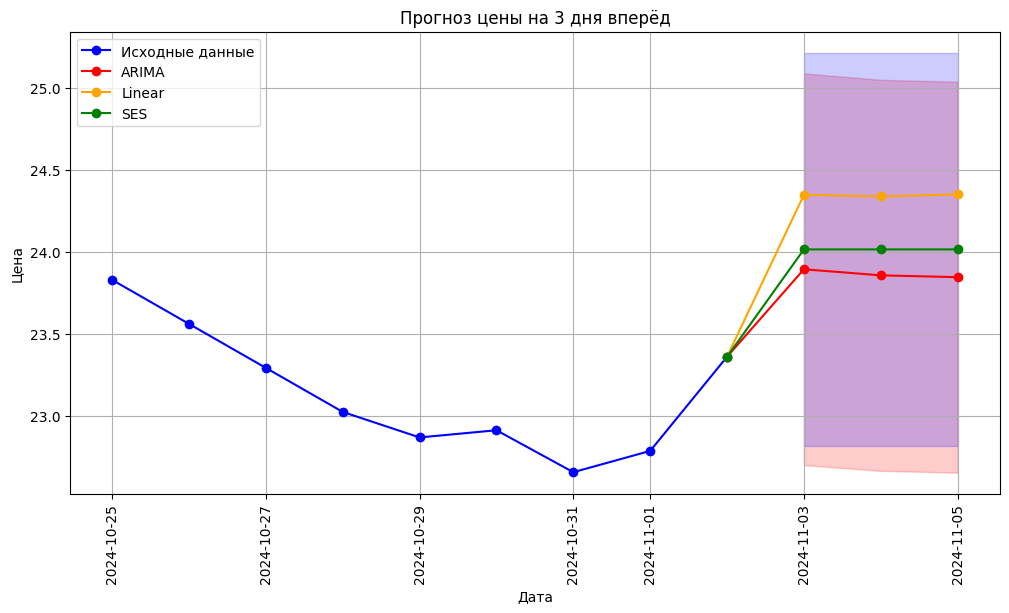


Обработка файла: datasets/сleaned\TATNP_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=6893.63)

Прогнозы для TATNP:
SES: [np.float64(583.237), np.float64(583.237), np.float64(583.237)]
ARIMA: [np.float64(581.338), np.float64(580.827), np.float64(580.687)]
Linear: [np.float64(587.364), np.float64(586.774), np.float64(586.544)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=12.676, MAPE=0.022, R2=-3.806
ARIMA: MAE=10.390, MAPE=0.018, R2=-2.477
Linear: MAE=16.333, MAPE=0.029, R2=-6.219

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=4.7187, MAPE=0.0082, R2=nan
  ARIMA: MAE=2.8202, MAPE=0.0049, R2=nan
  Linear: MAE=8.8456, MAPE=0.0153, R2=nan
День 2:
  SES:   MAE=12.6764, MAPE=0.0222, R2=nan
  ARIMA: MAE=10.2665, MAPE=0.0180, R2=nan
  Linear: MAE=16.2133, MAPE=0.0284, R2=nan
День 3:
  SES:   MAE=20.6341, MAPE=0.0367, R2=nan
  ARIMA: MAE=18.0843, MAPE=0.0321, R2=nan
  Linear: MAE=23.9413, MAPE=0

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


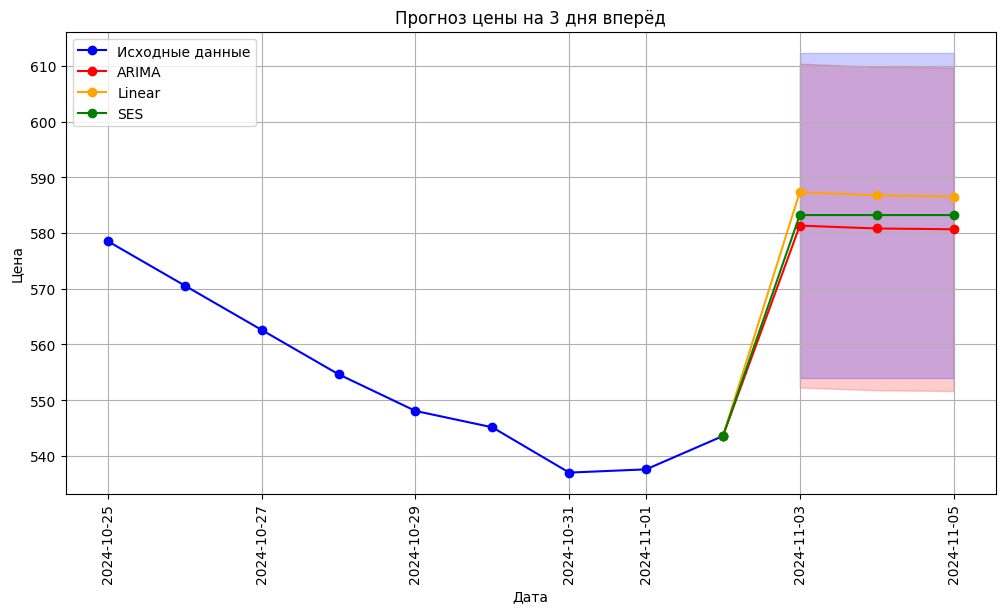


Обработка файла: datasets/сleaned\TATN_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=6982.50)

Прогнозы для TATN:
SES: [np.float64(584.839), np.float64(584.839), np.float64(584.839)]
ARIMA: [np.float64(583.083), np.float64(582.559), np.float64(582.402)]
Linear: [np.float64(588.639), np.float64(588.034), np.float64(587.776)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=12.903, MAPE=0.023, R2=-3.916
ARIMA: MAE=10.745, MAPE=0.019, R2=-2.633
Linear: MAE=16.214, MAPE=0.028, R2=-6.079

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=4.9176, MAPE=0.0085, R2=nan
  ARIMA: MAE=3.1615, MAPE=0.0055, R2=nan
  Linear: MAE=8.7172, MAPE=0.0150, R2=nan
День 2:
  SES:   MAE=12.9031, MAPE=0.0226, R2=nan
  ARIMA: MAE=10.6226, MAPE=0.0186, R2=nan
  Linear: MAE=16.0981, MAPE=0.0281, R2=nan
День 3:
  SES:   MAE=20.8885, MAPE=0.0370, R2=nan
  ARIMA: MAE=18.4515, MAPE=0.0327, R2=nan
  Linear: MAE=23.8255, MAPE=0.0

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


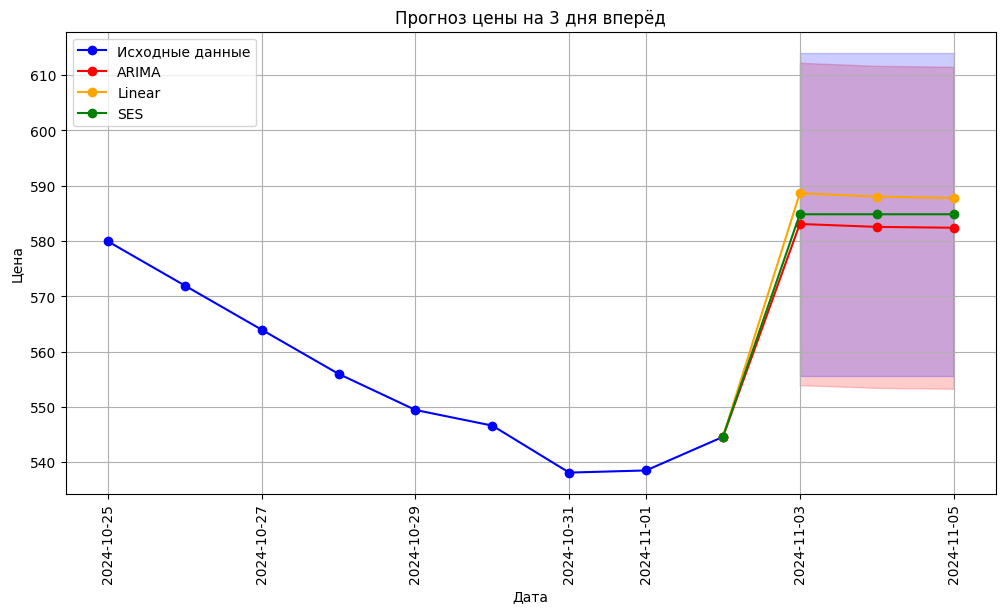


Обработка файла: datasets/сleaned\TRNFP_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Выбранные параметры ARIMA: p=1, d=1, q=2 (AIC=9334.02)

Прогнозы для TRNFP:
SES: [np.float64(1329.027), np.float64(1329.027), np.float64(1329.027)]
ARIMA: [np.float64(1328.288), np.float64(1327.851), np.float64(1327.5)]
Linear: [np.float64(1329.666), np.float64(1328.129), np.float64(1327.437)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=34.760, MAPE=0.027, R2=-6.383
ARIMA: MAE=33.612, MAPE=0.026, R2=-5.922
Linear: MAE=34.143, MAPE=0.026, R2=-6.031

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=17.9090, MAPE=0.0137, R2=nan
  ARIMA: MAE=17.1700, MAPE=0.0131, R2=nan
  Linear: MAE=18.5474, MAPE=0.0141, R2=nan
День 2:
  SES:   MAE=34.7597, MAPE=0.0269, R2=nan
  ARIMA: MAE=33.5834, MAPE=0.0259, R2=nan
  Linear: MAE=33.8610, MAPE=0.0262, R2=nan
День 3:
  SES:   MAE=51.6103, MAPE=0.0404, R2=nan
  ARIMA: MAE=50.0830, MAPE=0.0392, R2=nan
  Linear: MAE=50.02

c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


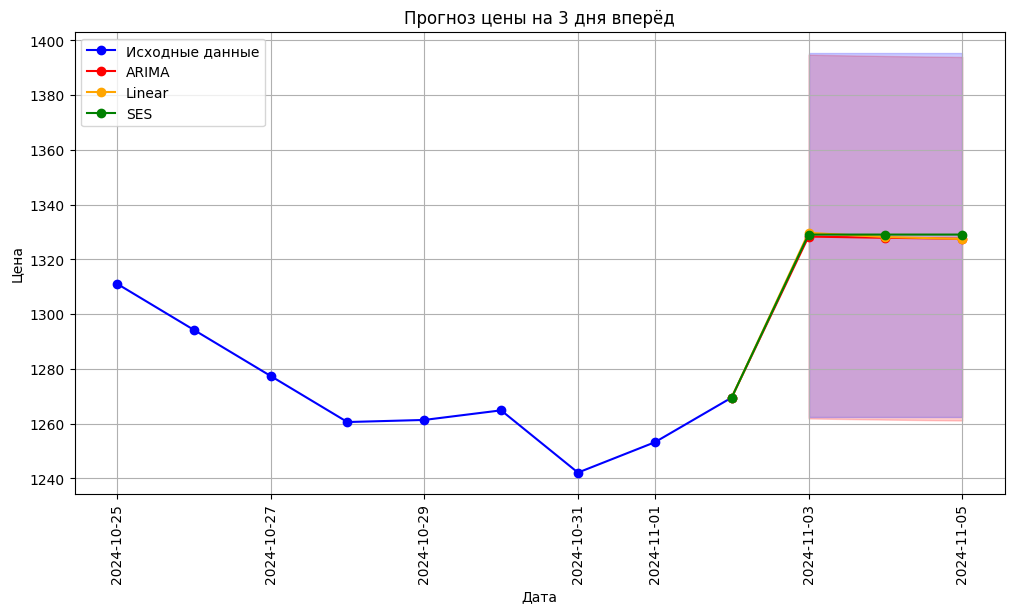


Обработка файла: datasets/сleaned\UPRO_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=-5121.83)

Прогнозы для UPRO:
SES: [np.float64(1.661), np.float64(1.661), np.float64(1.661)]
ARIMA: [np.float64(1.66), np.float64(1.659), np.float64(1.659)]
Linear: [np.float64(1.658), np.float64(1.657), np.float64(1.656)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=0.029, MAPE=0.018, R2=-3.333
ARIMA: MAE=0.027, MAPE=0.017, R2=-2.864
Linear: MAE=0.025, MAPE=0.016, R2=-2.420

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.0095, MAPE=0.0058, R2=nan
  ARIMA: MAE=0.0081, MAPE=0.0049, R2=nan
  Linear: MAE=0.0071, MAPE=0.0043, R2=nan
День 2:
  SES:   MAE=0.0290, MAPE=0.0178, R2=nan
  ARIMA: MAE=0.0270, MAPE=0.0165, R2=nan
  Linear: MAE=0.0248, MAPE=0.0152, R2=nan
День 3:
  SES:   MAE=0.0484, MAPE=0.0300, R2=nan
  ARIMA: MAE=0.0461, MAPE=0.0286, R2=nan
  Linear: MAE=0.0438, MAPE=0.0272, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


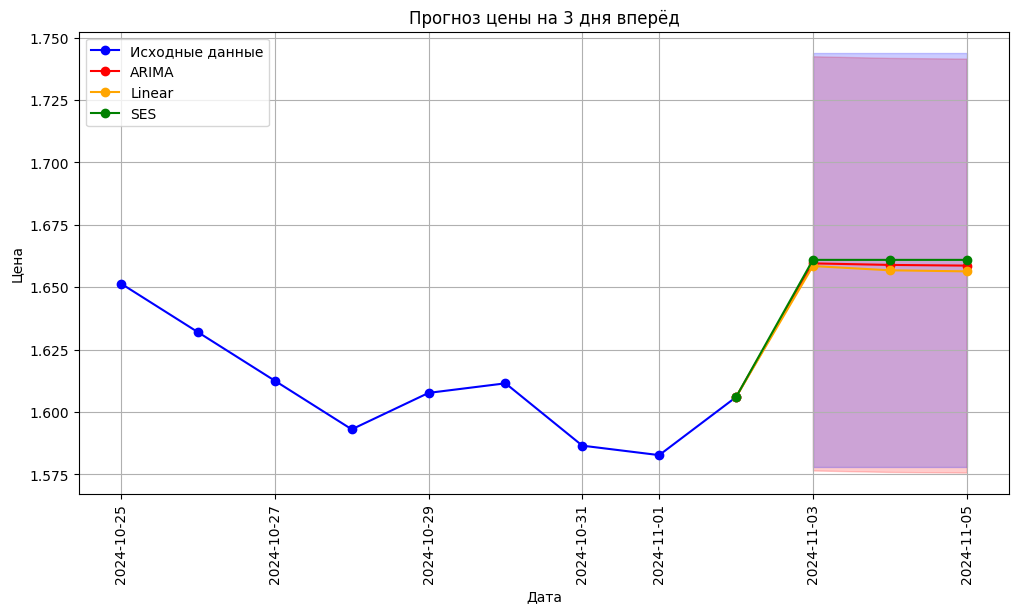


Обработка файла: datasets/сleaned\VTBR_cleaned.csv
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Параметр SES: alpha=1.0000
Выбранные параметры ARIMA: p=2, d=1, q=2 (AIC=4535.30)

Прогнозы для VTBR:
SES: [np.float64(82.208), np.float64(82.208), np.float64(82.208)]
ARIMA: [np.float64(81.718), np.float64(81.482), np.float64(81.359)]
Linear: [np.float64(82.618), np.float64(82.37), np.float64(82.278)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=1.930, MAPE=0.024, R2=-3.896
ARIMA: MAE=1.242, MAPE=0.016, R2=-1.338
Linear: MAE=2.144, MAPE=0.027, R2=-4.546

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=0.7324, MAPE=0.0090, R2=nan
  ARIMA: MAE=0.2431, MAPE=0.0030, R2=nan
  Linear: MAE=1.1425, MAPE=0.0140, R2=nan
День 2:
  SES:   MAE=1.9299, MAPE=0.0240, R2=nan
  ARIMA: MAE=1.2047, MAPE=0.0150, R2=nan
  Linear: MAE=2.0921, MAPE=0.0261, R2=nan
День 3:
  SES:   MAE=3.1273, MAPE=0.0395, R2=nan
  ARIMA: MAE=2.2790, MAPE=0.0288, R2=nan
  Linear: MAE=3.1973, MAPE=0.0404, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


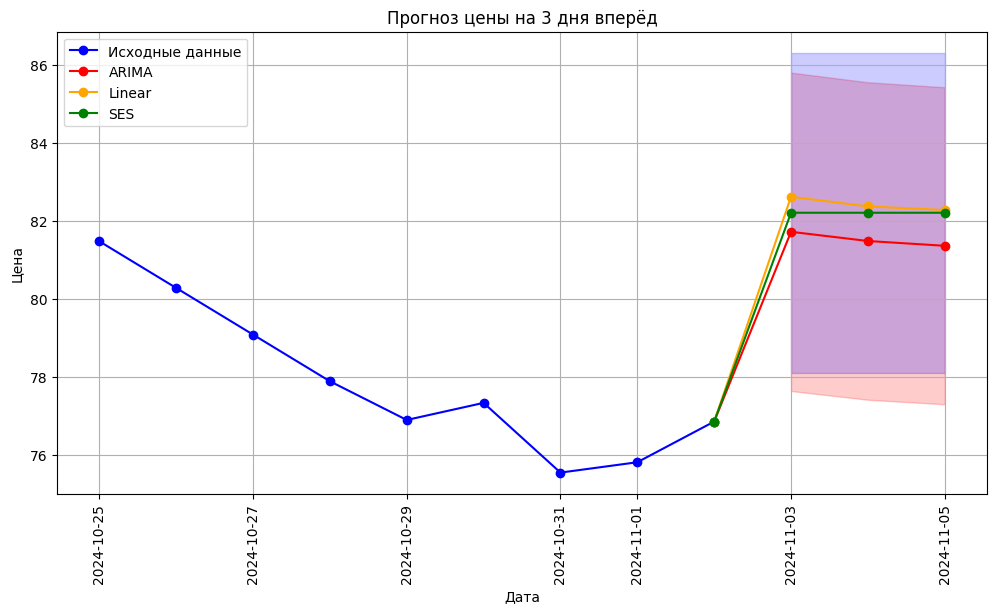


Обработка файла: datasets/сleaned\YDEX_cleaned.csv
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950
Параметр SES: alpha=0.9950


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Выбранные параметры ARIMA: p=1, d=1, q=1 (AIC=939.44)

Прогнозы для YDEX:
SES: [np.float64(3931.249), np.float64(3931.249), np.float64(3931.249)]
ARIMA: [np.float64(3932.157), np.float64(3932.498), np.float64(3932.627)]
Linear: [np.float64(3903.759), np.float64(3891.562), np.float64(3886.495)]

=== Итоговые метрики (3 дня) ===
SES:   MAE=71.707, MAPE=0.019, R2=-3.118
ARIMA: MAE=72.885, MAPE=0.019, R2=-3.231
Linear: MAE=38.075, MAPE=0.010, R2=-0.402

=== Метрики по каждому дню ===
День 1:
  SES:   MAE=21.9718, MAPE=0.0056, R2=nan
  ARIMA: MAE=22.8800, MAPE=0.0059, R2=nan
  Linear: MAE=5.5184, MAPE=0.0014, R2=nan
День 2:
  SES:   MAE=71.7068, MAPE=0.0186, R2=nan
  ARIMA: MAE=72.9559, MAPE=0.0189, R2=nan
  Linear: MAE=32.0198, MAPE=0.0083, R2=nan
День 3:
  SES:   MAE=121.4417, MAPE=0.0319, R2=nan
  ARIMA: MAE=122.8195, MAPE=0.0322, R2=nan
  Linear: MAE=76.6881, MAPE=0.0201, R2=nan


c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Nikita\anaconda3\envs\hse_year_project\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


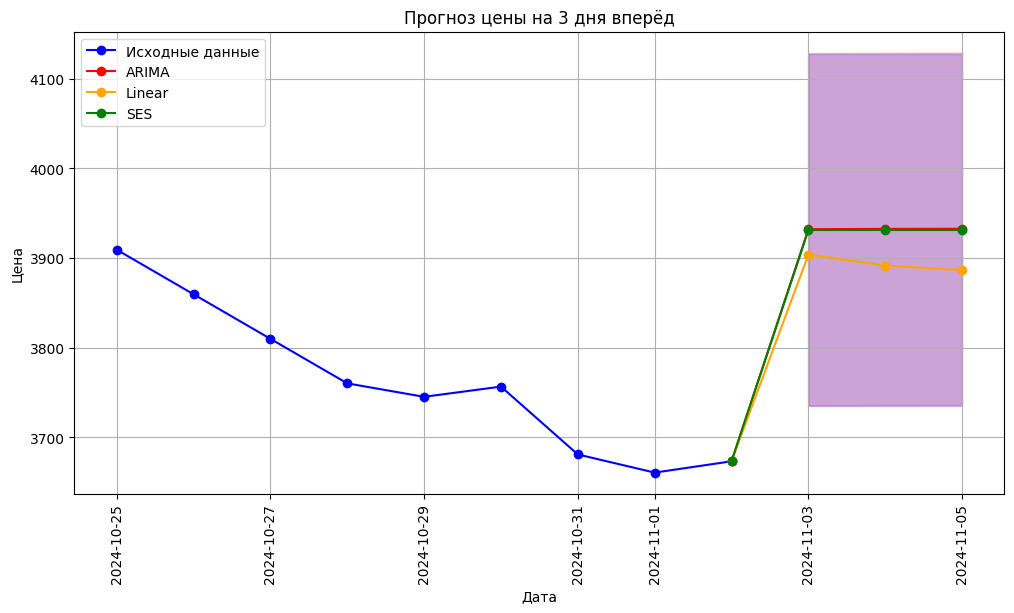


Все метрики сохранены в файл datasets/forecast_metrics/metrics_summary.csv


In [31]:
if __name__ == "__main__":
    main()